<a href="https://colab.research.google.com/github/gonzalopezgil/xlstm-ts/blob/main/notebooks/sp500_hourly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Movement Prediction Using Wavelet-Based xLSTM-TS Model

**Notebook 2**: S&P 500 - Hourly Prices

---


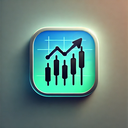

**Note**: Run with T4 GPU in Google Colab! (CUDA is required)

# Constants

**Dataset**: S&P 500 (US)

https://app.tiingo.com/spy/overview


NOTE for hourly data:
- The SPDR S&P 500 ETF Trust (SPY), also known as SPY, is an exchange-traded fund that tracks the performance of the S&P 500 index.
- It is chosen due to the unavailability of the S&P 500 in the Tiingo library.

In [ ]:
# Ticker (check in Yahoo Finance) and custom stock name
TICKER = 'SPY' # S&P 500 index
STOCK = 'S&P 500'

# Date range (YYYY-MM-DD) and frequency
START_DATE = '2020-07-13'
END_DATE = '2024-07-11'
FREQ = '1h' # hourly frequency

FILE_NAME = 'sp500_hourly' # custom file name

*   **Train**: 07/2020 - 06/2023
*   **Validation**: 07/2023 - 12/2023
*   **Test**: 01/2024 - 07/2024

In [ ]:
TRAIN_END_DATE = '2023-07-01'
VAL_END_DATE = '2024-01-01'

## Requirements

In [ ]:
repo_url = 'https://github.com/gonzalopezgil/xlstm-ts.git'

# Clone the repository
!git clone {repo_url}

Cloning into 'xlstm-ts'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (323/323), done.
remote: Compressing objects: 100% (230/230), done.
remote: Total 323 (delta 171), reused 229 (delta 88), pack-reused 0 (from 0)
Receiving objects: 100% (323/323), 11.52 MiB | 15.52 MiB/s, done.
Resolving deltas: 100% (171/171), done.


In [ ]:
%cd xlstm-ts

/content/xlstm-ts


NOTE: It can take a few minutes to install all dependencies.

In [ ]:
!pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 64.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.3 MB/s eta 0:00:00
Reason for being yanked: The Windows wheels, under some conditions, caused segfaults in unrelated user code.  Due to this we deleted the

In [ ]:
# Add the src directory to the Python path
import sys
import os

# Get the path of the current working directory
current_dir = os.getcwd()

# Construct the path to the 'src' directory in the current folder
src_path = os.path.join(current_dir, 'src')

# Add the 'src' directory to the Python path
if src_path not in sys.path:
    sys.path.append(src_path)

In [ ]:
from ml.utils.imports import *

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Optional: Retrieve MORE hourly data (API limitations apply)

(SKIP THIS STEP IF YOU DO NOT NEED HOURLY DATA MORE THAN 2 YEARS OLD)

**Where to find your Tiingo API Token?**

**Step 1: Create a Tiingo account if you have not already.**

You can do so by visit https://api.tiingo.com and clicking “Sign-up” in the top right corner.

**Step 2: Access the API Token Account Page.**

Visit https://api.tiingo.com/account/api/token to see your API Token and copy it below. Do not share it with anybody as this token will identify your usage with your account.

In [ ]:
os.environ['TIINGO_API_KEY'] = '' # Add your Tiingo API key here

## Dataset

In [ ]:
from ml.data.download import download_data
from ml.utils.visualisation import plot_data

### **Optional: Read local files**

If you want to read the given data from the experiment, UNCOMMENT this code snippet and COMMENT OUT the regular download to proceed.

(NOTE: The regular download will retrieve the exact same data by default, you can experiment with the constants at the top of the file to change it)

In [ ]:
'''
# Read the CSV file and set the "Date" column as the index
file_path = os.path.join('data', 'datasets', FILE_NAME + '.csv')
df = pd.read_csv(file_path, header=0, index_col='Date')
# Convert the index to a datetime object
df.index = df.index.to_series().apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z"))
'''

'\n# Read the CSV file and set the "Date" column as the index\nfile_path = os.path.join(\'data\', \'datasets\', FILE_NAME + \'.csv\')\ndf = pd.read_csv(file_path, header=0, index_col=\'Date\')\n# Convert the index to a datetime object\ndf.index = df.index.to_series().apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z"))\n'

### Download data

- **Tiingo**: If the frequency is hourly and the starting date is more than 2 years before, the Tiingo API will be used. You need to enter the API key to proceed (the steps are explained above). Note that restrictive API limitations apply.

- **Yahoo Finance**: In all other cases, Yahoo Finance will be used. There's no need to enter an API key to download data from it, and there are no API restrictions with responsible usage.

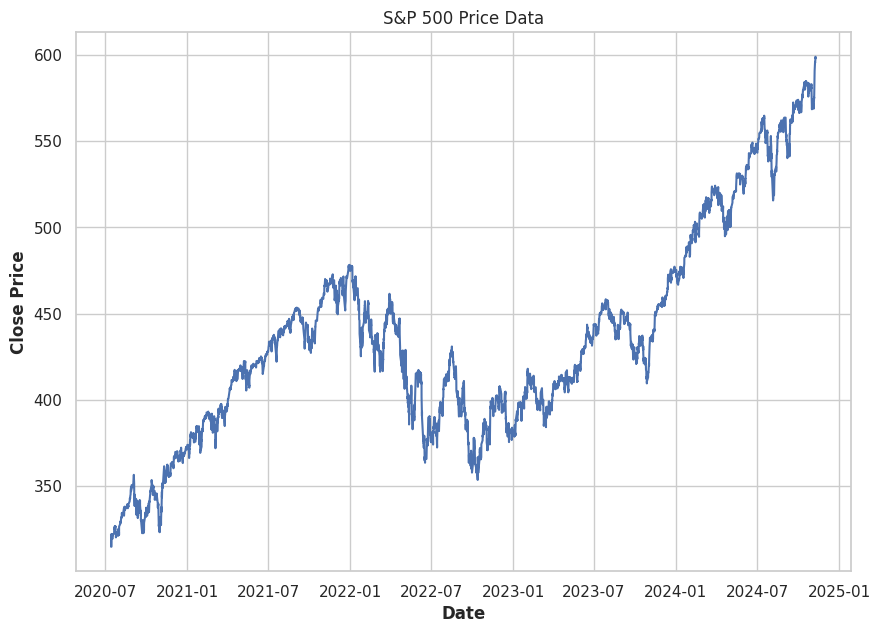

In [ ]:
# Download the data
df = download_data(ticker=TICKER, start_date=START_DATE, end_date=END_DATE, freq=FREQ)

# Plot the raw data
plot_data(df, STOCK)

## Preprocessing

### Wavelet denoising

Reference:
https://doi.org/10.1002/for.3071 (the idea of the wavelet denoising and some parameters are taken from this paper)

In [ ]:
from ml.data.preprocessing import wavelet_denoising, plot_wavelet_denoising

Signal-to-Noise Ratio (SNR): 56.85 dB


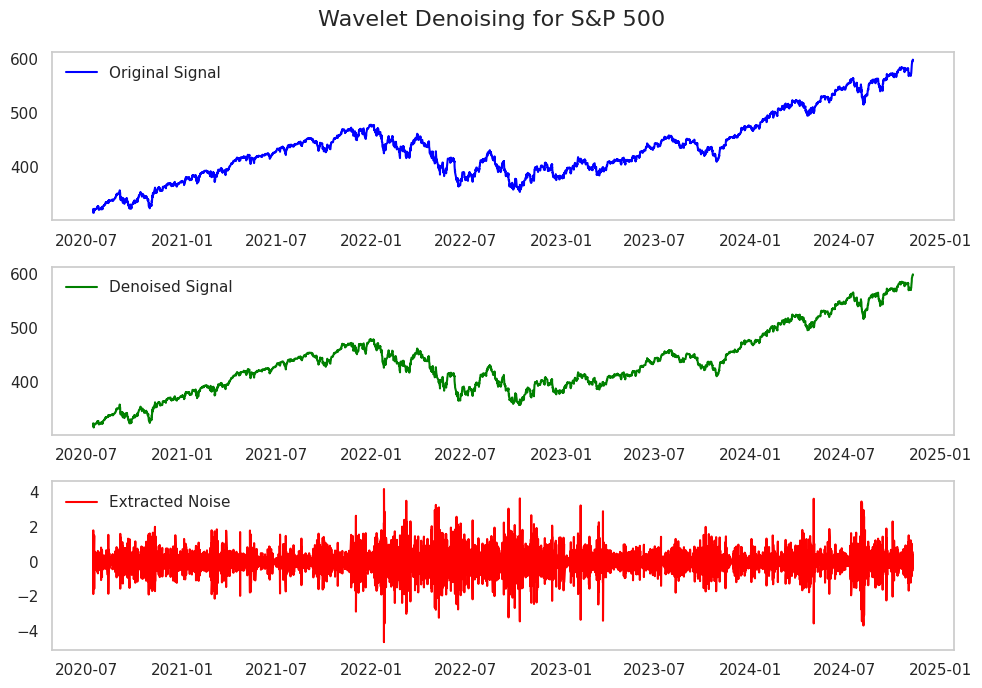

In [ ]:
# Apply denoising
df['Close_denoised'] = wavelet_denoising(df['Close'])
df['Noise'] = df['Close'] - df['Close_denoised']

plot_wavelet_denoising(df, STOCK)

### Process dates

In [ ]:
from ml.data.preprocessing import process_dates

In [ ]:
# Convert the Date column to time zone-naive datetime
df = process_dates(df)

### Model-specific preprocessing

#### For darts library models

##### Convert to darts TimeSeries

**Darts Library**:

- Paper: https://www.jmlr.org/papers/v23/21-1177.html
- Documentation: https://unit8co.github.io/darts/README.html#
- Repository: https://github.com/unit8co/darts

In [ ]:
from ml.models.darts.preprocessing import convert_to_ts_hourly

In [ ]:
series, series_denoised = convert_to_ts_hourly(df)
series_denoised

<TimeSeries (DataArray) (time: 6780, component: 1, sample: 1)> Size: 54kB
array([[[321.51729847]],

       [[321.80057435]],

       [[322.5020583 ]],

       ...,

       [[598.66936746]],

       [[598.66491121]],

       [[598.48200973]]])
Coordinates:
  * time       (time) datetime64[ns] 54kB 2020-07-13T14:00:00 ... 2024-11-08T...
  * component  (component) <U1 4B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

##### Train, Validation and Test split

In [ ]:
from ml.models.darts.preprocessing import split_train_val_test_darts

In [ ]:
# Transform the string dates into datetime objects
TRAIN_END_DATE = datetime.datetime.strptime(TRAIN_END_DATE, '%Y-%m-%d')
VAL_END_DATE = datetime.datetime.strptime(VAL_END_DATE, '%Y-%m-%d')

In [ ]:
train, val, test = split_train_val_test_darts(series, TRAIN_END_DATE, VAL_END_DATE)
train_denoised, val_denoised, test_denoised = split_train_val_test_darts(series_denoised, TRAIN_END_DATE, VAL_END_DATE)

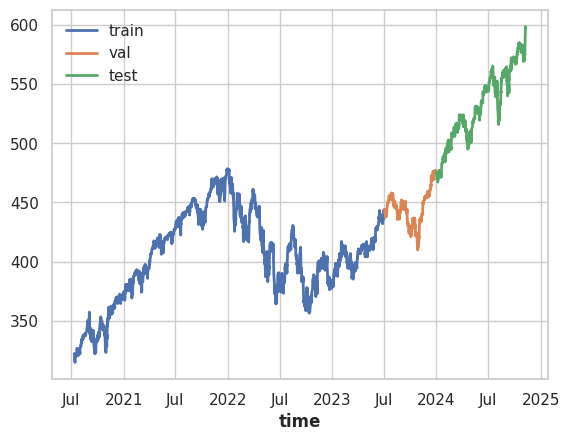

In [ ]:
train_denoised.plot(label="train");
val_denoised.plot(label="val");
test_denoised.plot(label="test");

##### Normalise data

In [ ]:
from ml.models.darts.preprocessing import normalise_split_data_darts

In [ ]:
train, val, test, scaler_darts = normalise_split_data_darts(train, val, test)
train_denoised, val_denoised, test_denoised, scaler_darts_denoised = normalise_split_data_darts(train_denoised, val_denoised, test_denoised)

#### For the proposed model

##### Normalise data

In [ ]:
from ml.models.xlstm_ts.preprocessing import normalise_data_xlstm

In [ ]:
close_scaled, scaler = normalise_data_xlstm(df['Close'].values)

In [ ]:
close_scaled_denoised, scaler_denoised = normalise_data_xlstm(df['Close_denoised'].values)

##### Create sequences

In [ ]:
from ml.models.xlstm_ts.preprocessing import create_sequences

In [ ]:
X, y, dates = create_sequences(close_scaled, df.index)

In [ ]:
X_denoised, y_denoised, _ = create_sequences(close_scaled_denoised, df.index)

##### Train, Validation and Test split

In [ ]:
from ml.models.xlstm_ts.preprocessing import split_train_val_test_xlstm

train X shape: torch.Size([4500, 150, 1])
train y shape: torch.Size([4500, 1])
val X shape: torch.Size([780, 150, 1])
val y shape: torch.Size([780, 1])
test X shape: torch.Size([1350, 150, 1])
test y shape: torch.Size([1350, 1])


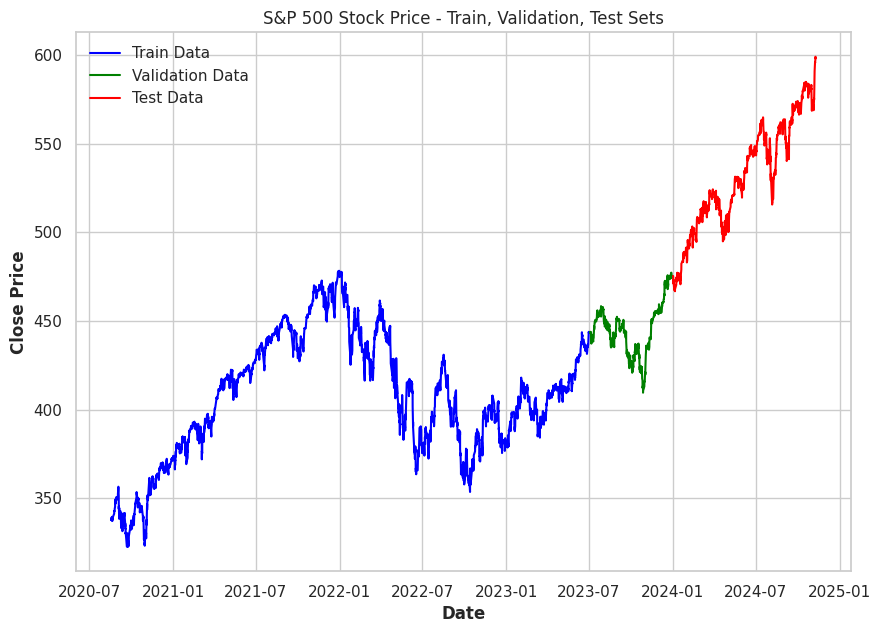

In [ ]:
train_X, train_y, train_dates, val_X, val_y, val_dates, test_X, test_y, test_dates = split_train_val_test_xlstm(X, y, dates, TRAIN_END_DATE, VAL_END_DATE, scaler, STOCK)

train X shape: torch.Size([4500, 150, 1])
train y shape: torch.Size([4500, 1])
val X shape: torch.Size([780, 150, 1])
val y shape: torch.Size([780, 1])
test X shape: torch.Size([1350, 150, 1])
test y shape: torch.Size([1350, 1])


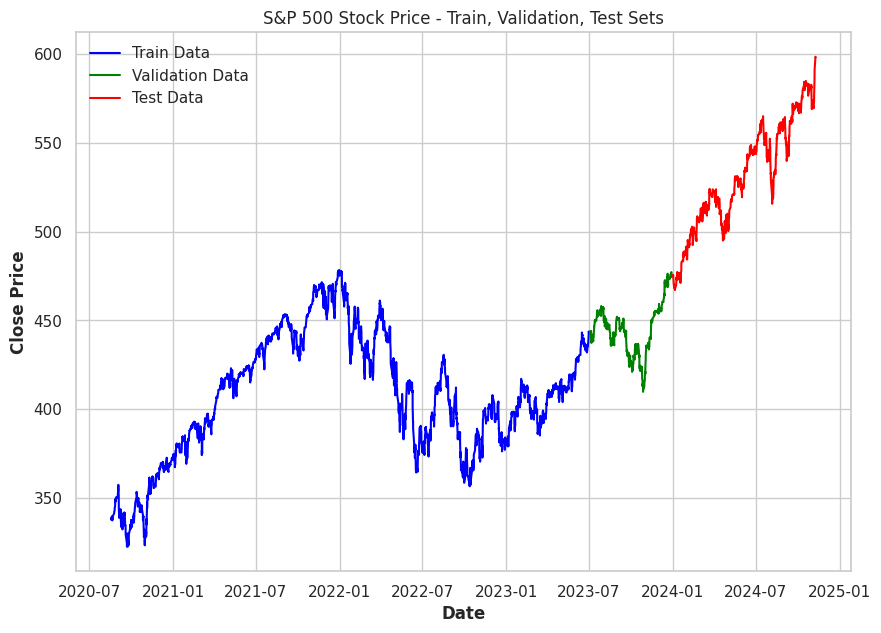

In [ ]:
train_X_denoised, train_y_denoised, _, val_X_denoised, val_y_denoised, _, test_X_denoised, test_y_denoised, _ = split_train_val_test_xlstm(X_denoised, y_denoised, dates, TRAIN_END_DATE, VAL_END_DATE, scaler_denoised, STOCK)

## Models

In [ ]:
from ml.models.shared.directional_prediction import *
from ml.models.shared.metrics import *
from ml.models.shared.visualisation import *
from ml.models.darts.darts_models import *
from ml.models.darts.training import *

In [ ]:
metrics_accumulator = {}
metrics_accumulator_denoised = {}

### TCN

**References**:

- Paper (2018): https://doi.org/10.48550/arXiv.1803.01271
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tcn_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/05-TCN-examples.html

**Not denoised**

Price Prediction Metrics:

TCN (Original) | MAE: 1.21
TCN (Original) | MSE: 3.50
TCN (Original) | RMSE: 1.87
TCN (Original) | RMSSE: 1.05
TCN (Original) | MAPE: 0.23%
TCN (Original) | MASE: 1.12
TCN (Original) | R2: 1.00


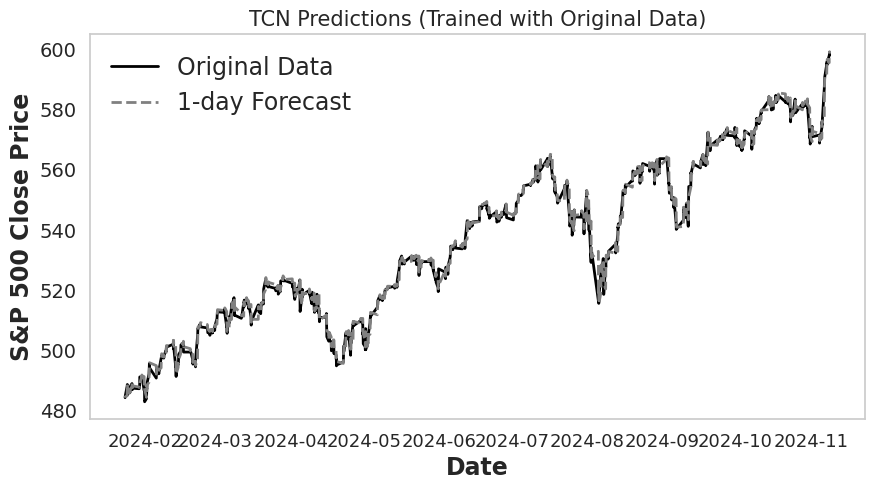

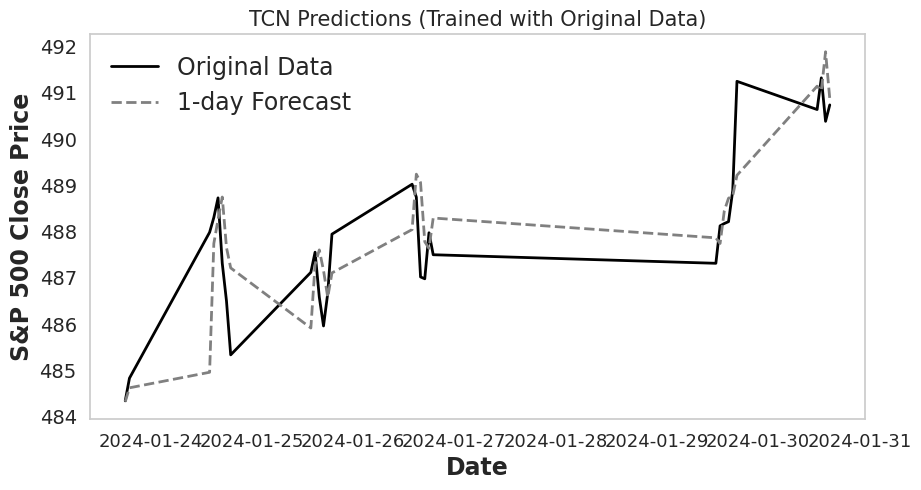


Directional Movement Metrics:

TCN (Original) | Train Accuracy: 51.42%
TCN (Original) | Validation Accuracy: 49.04%
TCN (Original) | Test Accuracy: 48.52%
TCN (Original) | Recall: 53.81%
TCN (Original) | Precision (Rise): 50.94%
TCN (Original) | Precision (Fall): 45.50%
TCN (Original) | F1 Score: 52.34%


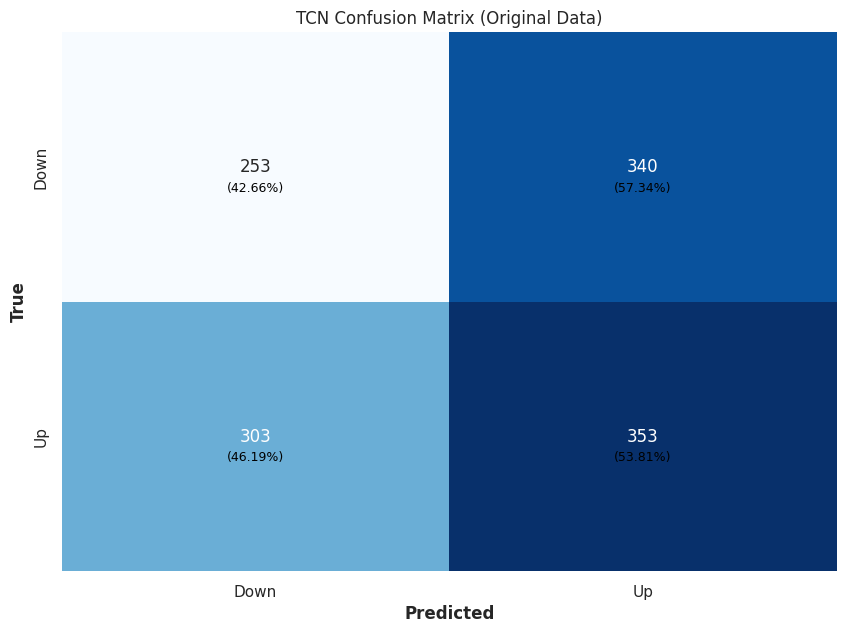

In [ ]:
model = get_model_tcn()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Price Prediction Metrics:

TCN (Denoised) | MAE: 1.08
TCN (Denoised) | MSE: 2.70
TCN (Denoised) | RMSE: 1.64
TCN (Denoised) | RMSSE: 0.92
TCN (Denoised) | MAPE: 0.20%
TCN (Denoised) | MASE: 1.00
TCN (Denoised) | R2: 1.00


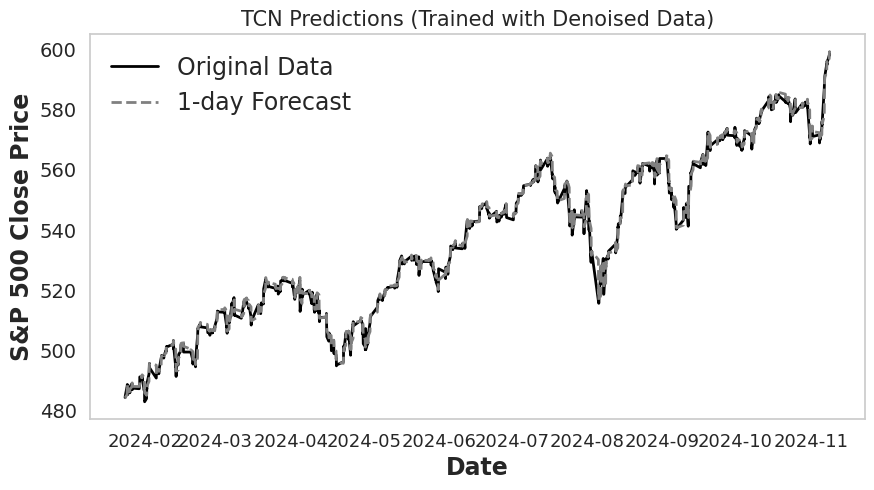

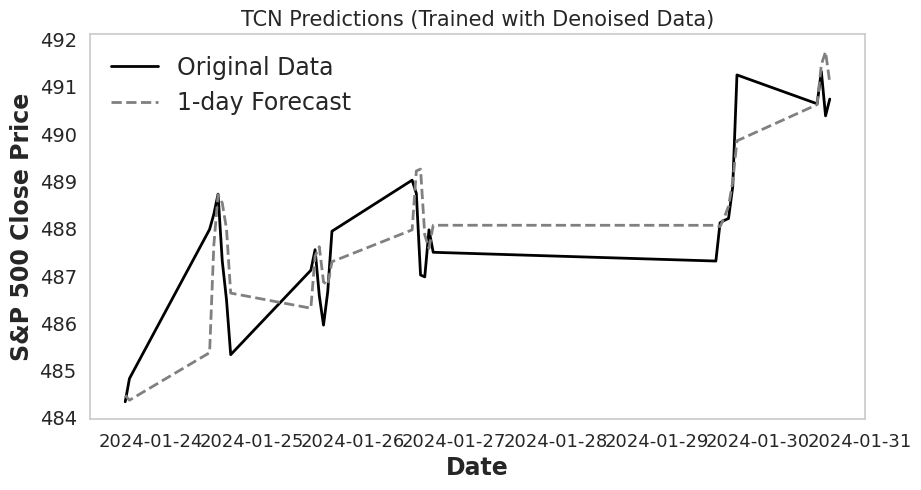


Directional Movement Metrics:

TCN (Denoised) | Train Accuracy: 64.15%
TCN (Denoised) | Validation Accuracy: 60.82%
TCN (Denoised) | Test Accuracy: 62.69%
TCN (Denoised) | Recall: 67.84%
TCN (Denoised) | Precision (Rise): 63.57%
TCN (Denoised) | Precision (Fall): 61.57%
TCN (Denoised) | F1 Score: 65.63%


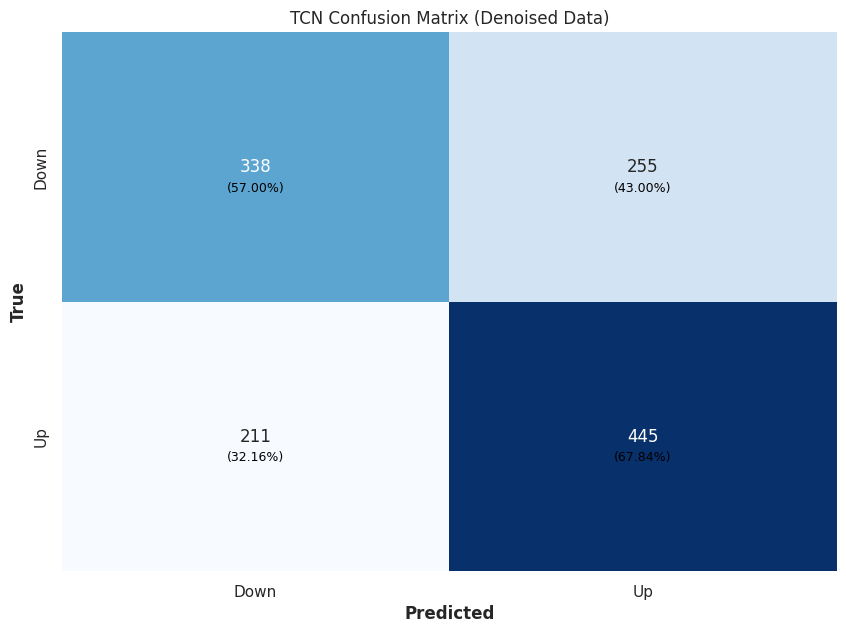

In [ ]:
model = get_model_tcn()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### DeepTCN

**References**:

- Paper (2020): https://doi.org/10.48550/arXiv.1906.04397
- Code (same as TCN): https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tcn_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/09-DeepTCN-examples.html

**Not denoised**

Price Prediction Metrics:

DeepTCN (Original) | MAE: 1.53
DeepTCN (Original) | MSE: 4.87
DeepTCN (Original) | RMSE: 2.21
DeepTCN (Original) | RMSSE: 1.24
DeepTCN (Original) | MAPE: 0.28%
DeepTCN (Original) | MASE: 1.42
DeepTCN (Original) | R2: 0.99


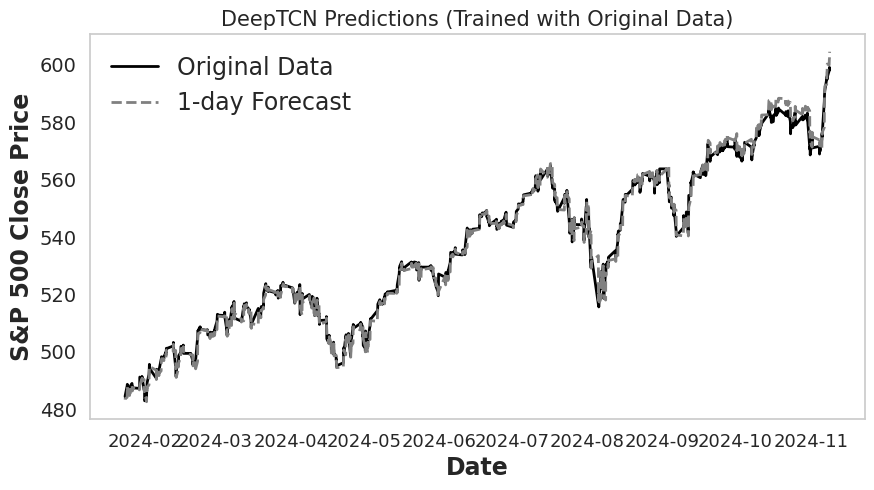

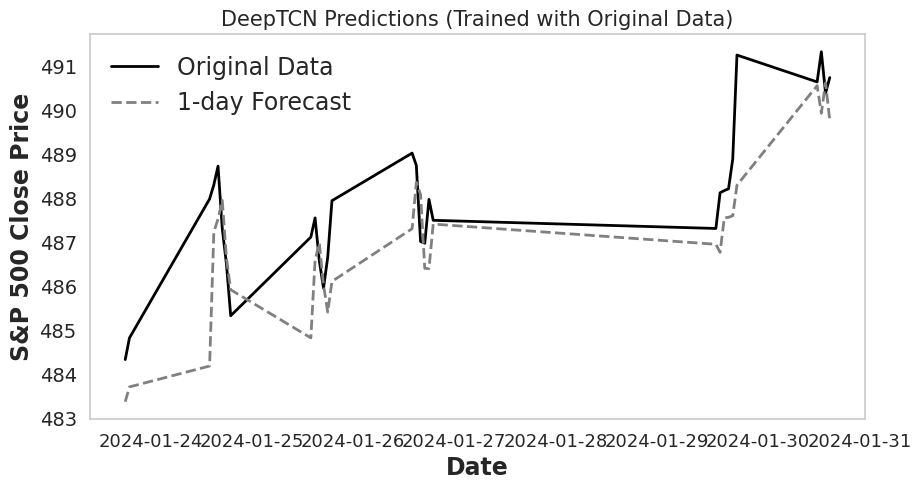


Directional Movement Metrics:

DeepTCN (Original) | Train Accuracy: 50.63%
DeepTCN (Original) | Validation Accuracy: 45.36%
DeepTCN (Original) | Test Accuracy: 49.80%
DeepTCN (Original) | Recall: 54.12%
DeepTCN (Original) | Precision (Rise): 52.13%
DeepTCN (Original) | Precision (Fall): 47.01%
DeepTCN (Original) | F1 Score: 53.10%


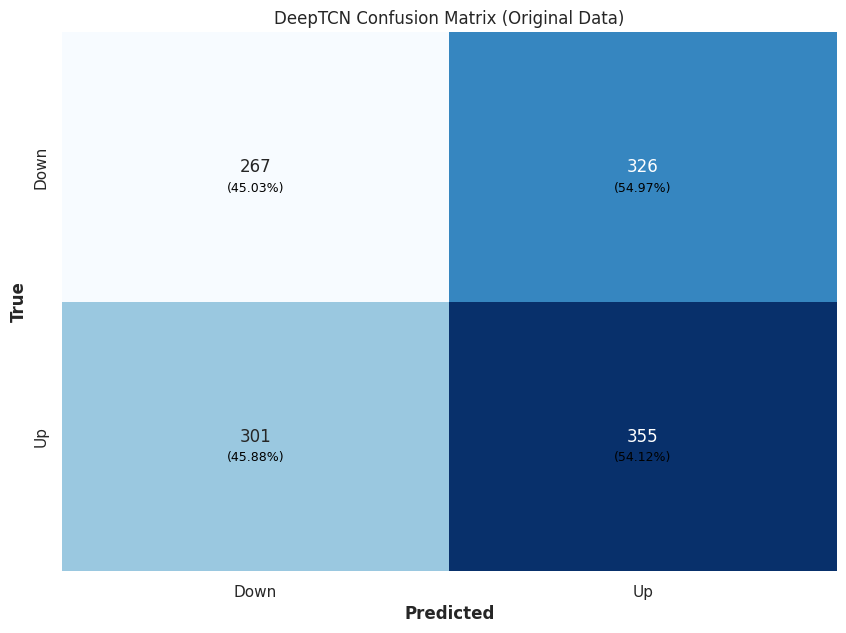

In [ ]:
model = get_model_deeptcn()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Price Prediction Metrics:

DeepTCN (Denoised) | MAE: 1.35
DeepTCN (Denoised) | MSE: 3.87
DeepTCN (Denoised) | RMSE: 1.97
DeepTCN (Denoised) | RMSSE: 1.10
DeepTCN (Denoised) | MAPE: 0.25%
DeepTCN (Denoised) | MASE: 1.25
DeepTCN (Denoised) | R2: 0.99


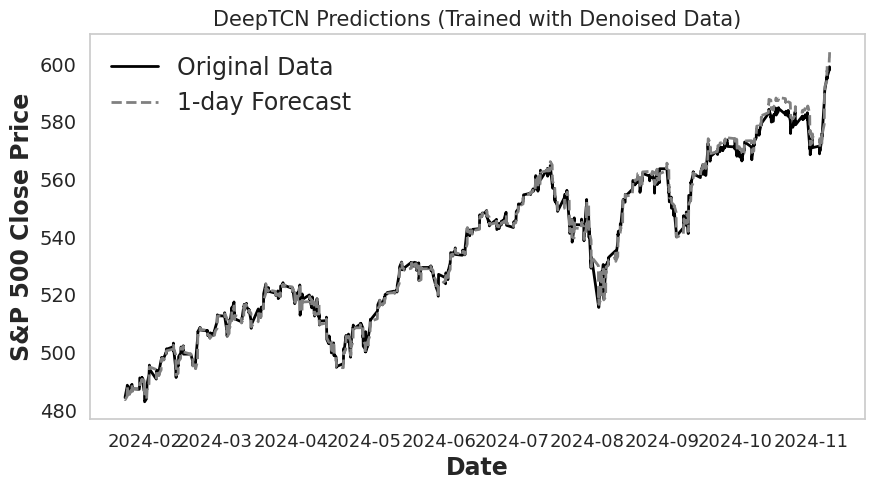

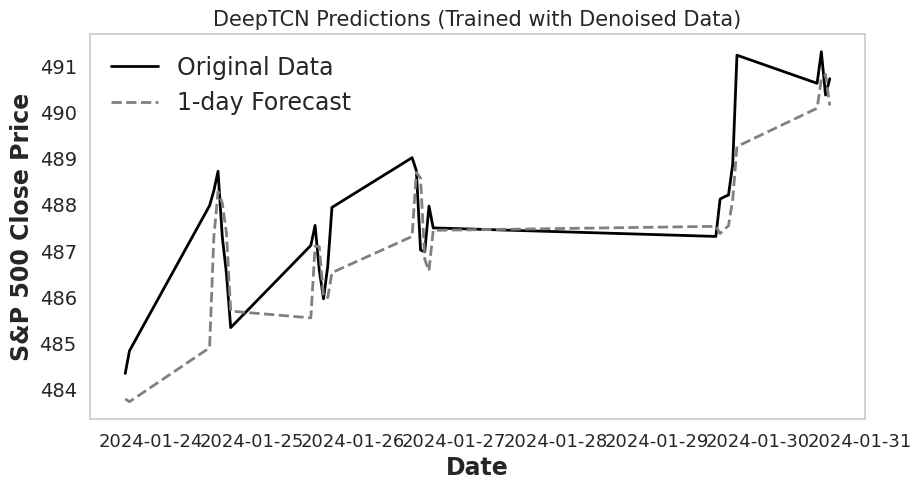


Directional Movement Metrics:

DeepTCN (Denoised) | Train Accuracy: 65.09%
DeepTCN (Denoised) | Validation Accuracy: 62.15%
DeepTCN (Denoised) | Test Accuracy: 62.05%
DeepTCN (Denoised) | Recall: 65.55%
DeepTCN (Denoised) | Precision (Rise): 63.42%
DeepTCN (Denoised) | Precision (Fall): 60.42%
DeepTCN (Denoised) | F1 Score: 64.47%


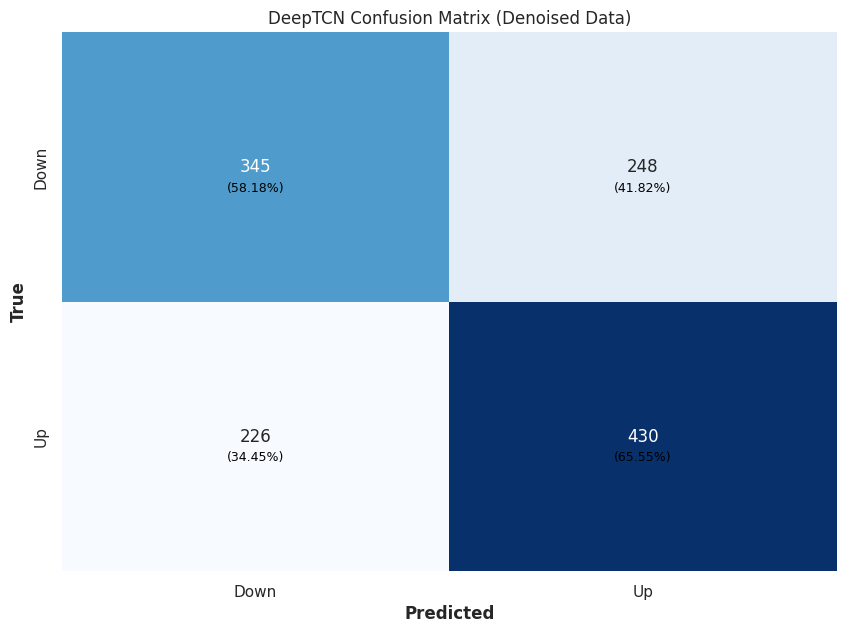

In [ ]:
model = get_model_deeptcn()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### N-BEATS

**References**:
- Paper (2020): https://doi.org/10.48550/arXiv.1905.10437
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/nbeats.py
- Darts documentation: https://unit8co.github.io/darts/examples/07-NBEATS-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-BEATS (Original) | MAE: 1.72
N-BEATS (Original) | MSE: 6.48
N-BEATS (Original) | RMSE: 2.55
N-BEATS (Original) | RMSSE: 1.43
N-BEATS (Original) | MAPE: 0.32%
N-BEATS (Original) | MASE: 1.60
N-BEATS (Original) | R2: 0.99


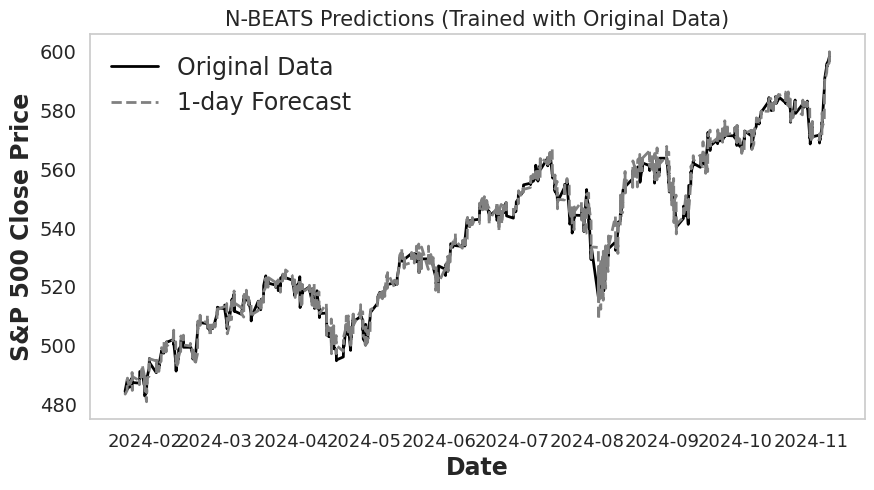

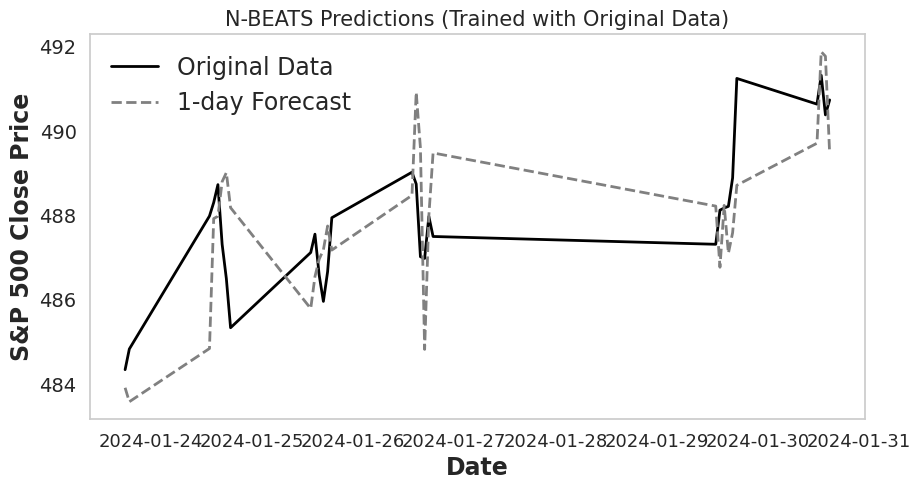


Directional Movement Metrics:

N-BEATS (Original) | Train Accuracy: 54.01%
N-BEATS (Original) | Validation Accuracy: 51.40%
N-BEATS (Original) | Test Accuracy: 52.36%
N-BEATS (Original) | Recall: 54.12%
N-BEATS (Original) | Precision (Rise): 54.70%
N-BEATS (Original) | Precision (Fall): 49.83%
N-BEATS (Original) | F1 Score: 54.41%


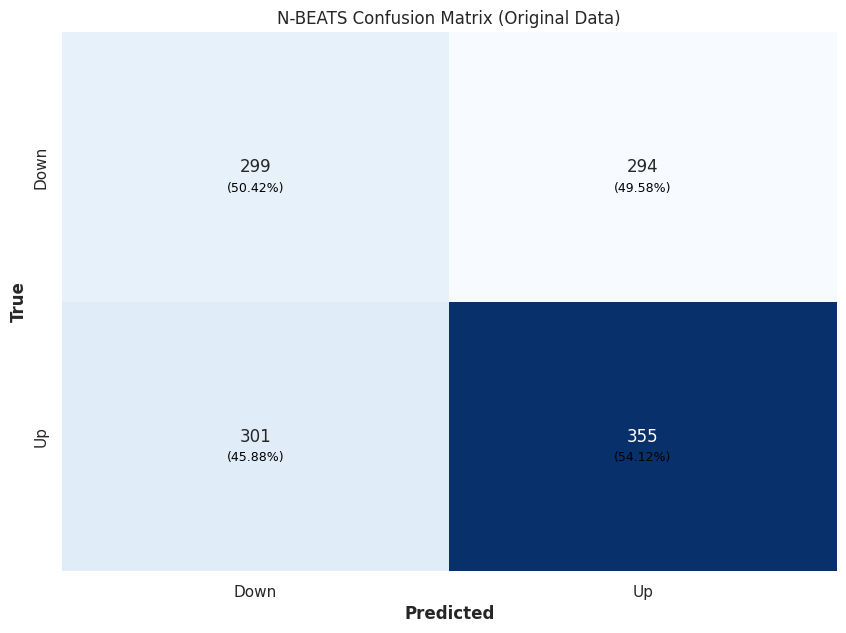

In [ ]:
model = get_model_nbeats()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-BEATS (Denoised) | MAE: 1.26
N-BEATS (Denoised) | MSE: 3.40
N-BEATS (Denoised) | RMSE: 1.84
N-BEATS (Denoised) | RMSSE: 1.03
N-BEATS (Denoised) | MAPE: 0.24%
N-BEATS (Denoised) | MASE: 1.17
N-BEATS (Denoised) | R2: 1.00


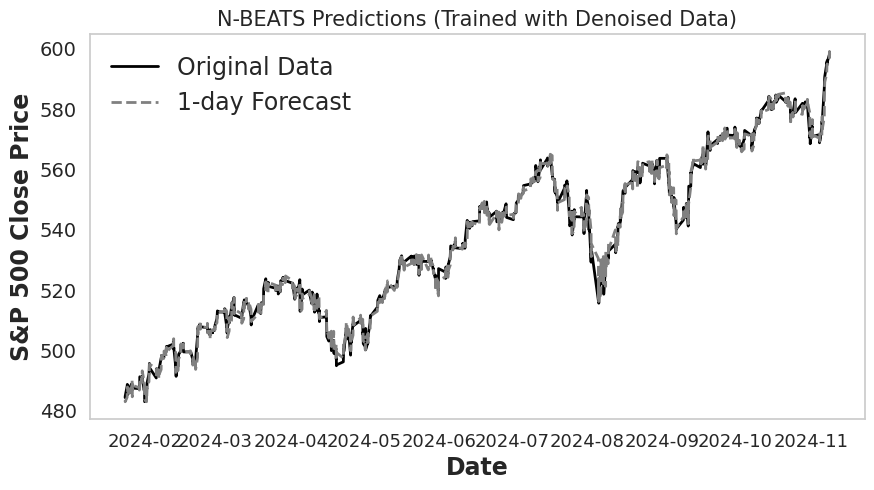

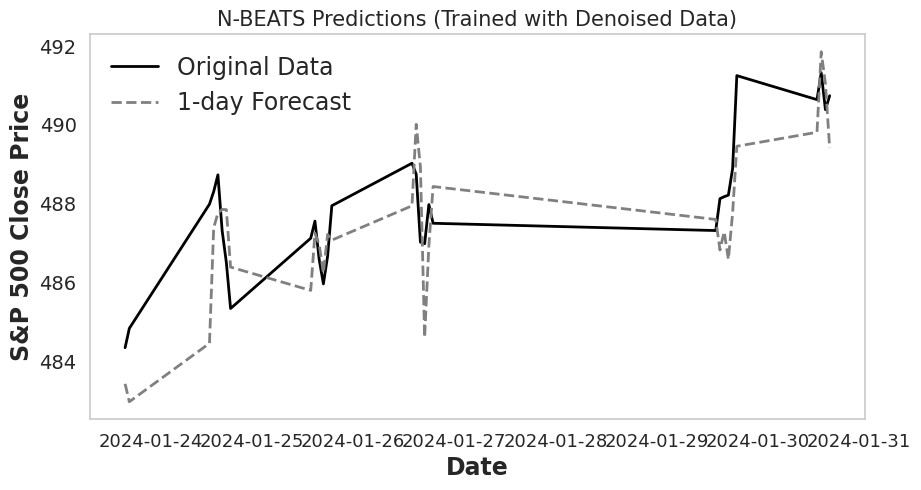


Directional Movement Metrics:

N-BEATS (Denoised) | Train Accuracy: 62.21%
N-BEATS (Denoised) | Validation Accuracy: 57.73%
N-BEATS (Denoised) | Test Accuracy: 59.17%
N-BEATS (Denoised) | Recall: 62.65%
N-BEATS (Denoised) | Precision (Rise): 60.80%
N-BEATS (Denoised) | Precision (Fall): 57.24%
N-BEATS (Denoised) | F1 Score: 61.71%


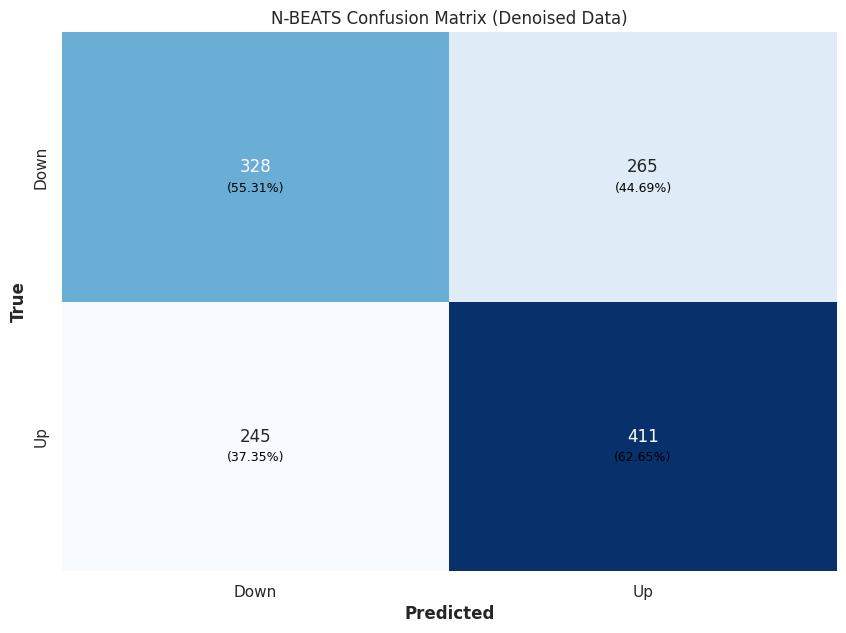

In [ ]:
model = get_model_nbeats()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### TFT

Temporal Fusion Transformer Model

**References**:

- Paper (2021): https://doi.org/10.1016/j.ijforecast.2021.03.012
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tft_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/13-TFT-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TFT (Original) | MAE: 2.97
TFT (Original) | MSE: 21.32
TFT (Original) | RMSE: 4.62
TFT (Original) | RMSSE: 2.59
TFT (Original) | MAPE: 0.55%
TFT (Original) | MASE: 2.75
TFT (Original) | R2: 0.97


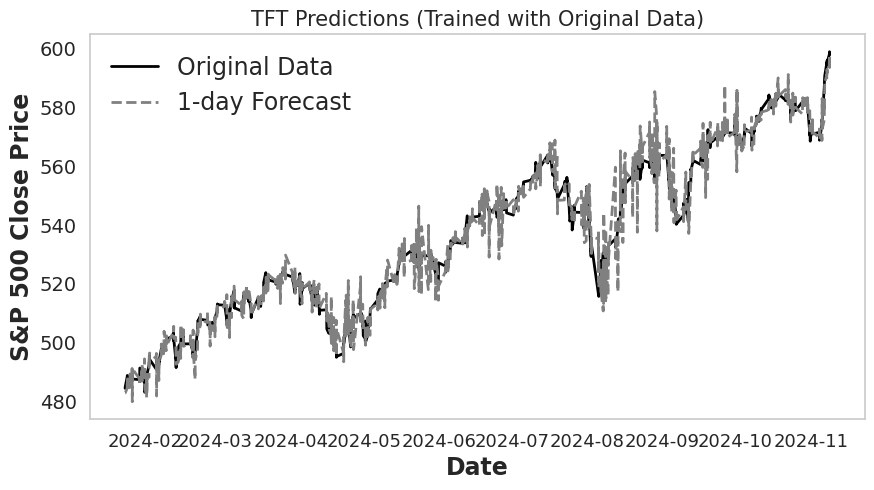

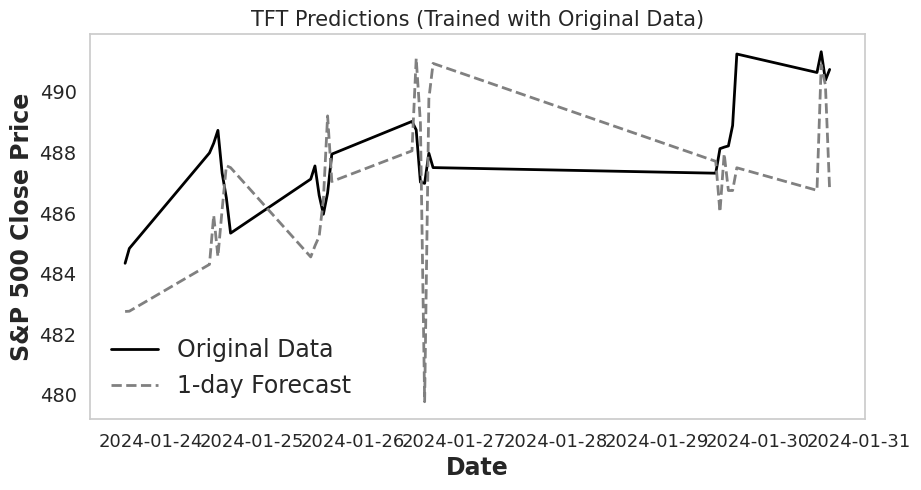


Directional Movement Metrics:

TFT (Original) | Train Accuracy: 50.74%
TFT (Original) | Validation Accuracy: 50.52%
TFT (Original) | Test Accuracy: 51.56%
TFT (Original) | Recall: 52.74%
TFT (Original) | Precision (Rise): 53.98%
TFT (Original) | Precision (Fall): 49.01%
TFT (Original) | F1 Score: 53.35%


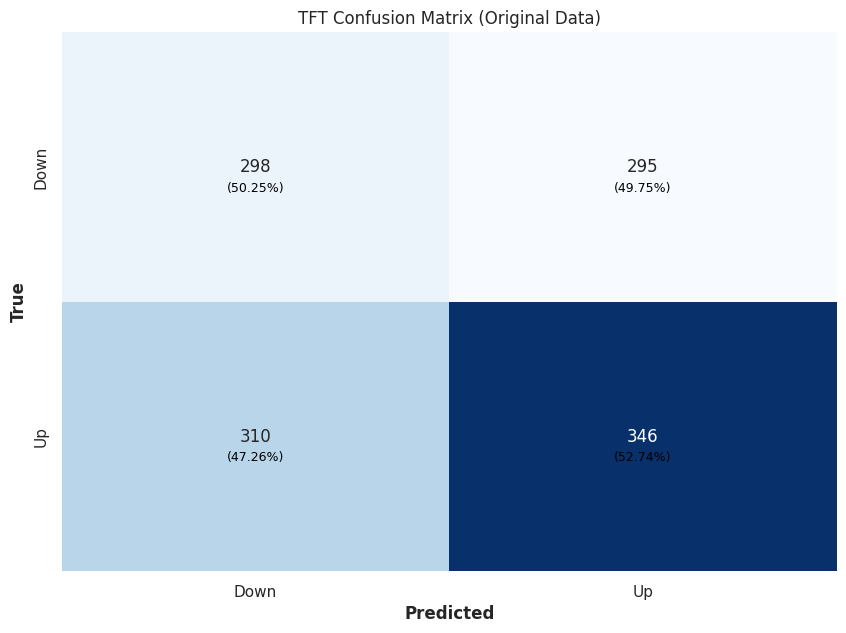

In [ ]:
model = get_model_tft()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TFT (Denoised) | MAE: 2.88
TFT (Denoised) | MSE: 20.39
TFT (Denoised) | RMSE: 4.52
TFT (Denoised) | RMSSE: 2.53
TFT (Denoised) | MAPE: 0.54%
TFT (Denoised) | MASE: 2.67
TFT (Denoised) | R2: 0.97


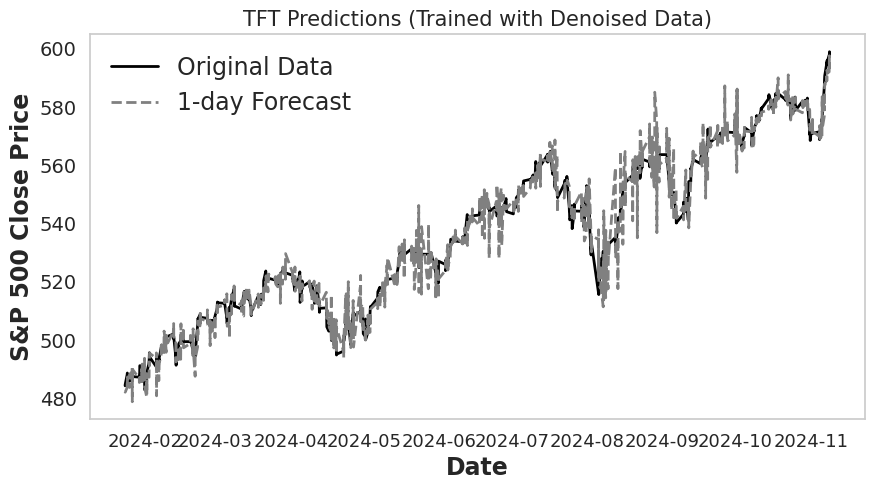

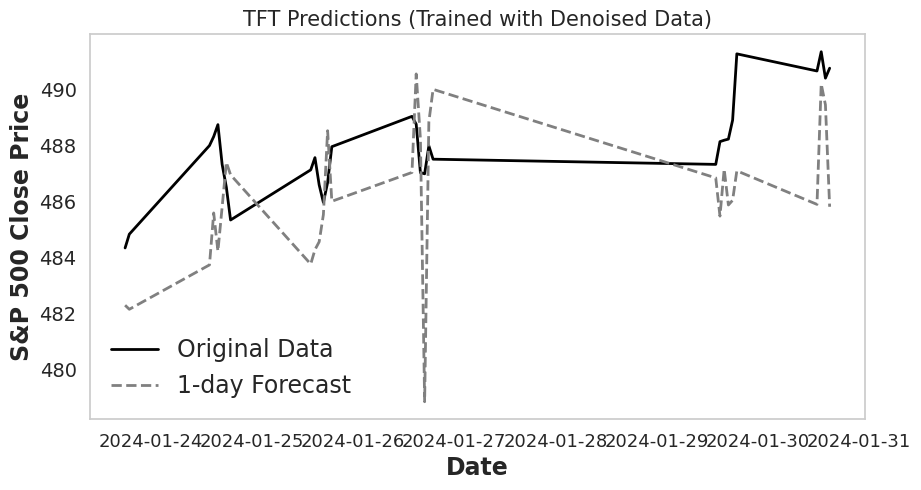


Directional Movement Metrics:

TFT (Denoised) | Train Accuracy: 53.29%
TFT (Denoised) | Validation Accuracy: 51.69%
TFT (Denoised) | Test Accuracy: 52.84%
TFT (Denoised) | Recall: 53.96%
TFT (Denoised) | Precision (Rise): 55.23%
TFT (Denoised) | Precision (Fall): 50.33%
TFT (Denoised) | F1 Score: 54.59%


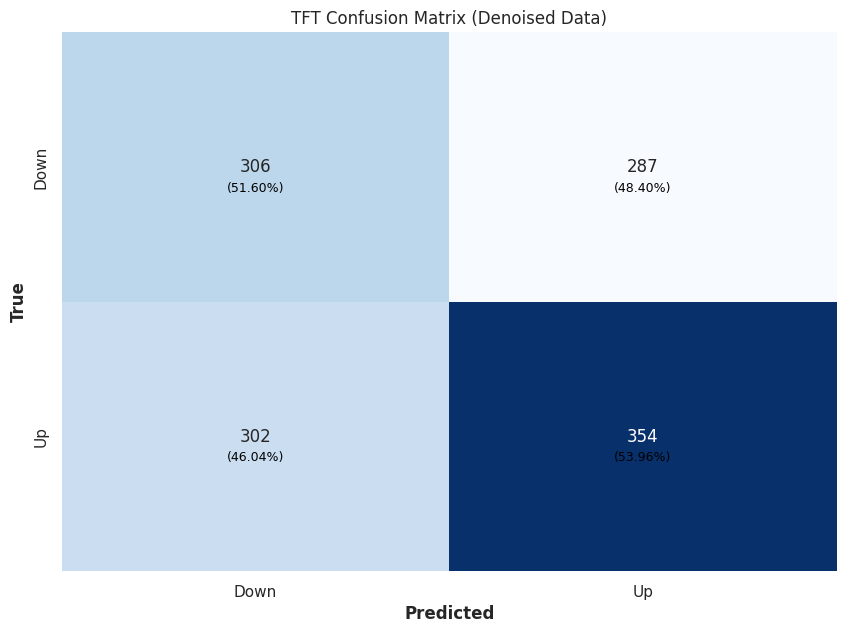

In [ ]:
model = get_model_tft()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### TiDE

TimeSeries Dense Encoder Model

**References**:
- Paper (2024): https://doi.org/10.48550/arXiv.2304.08424
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tide_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/18-TiDE-examples.html

**+RIN**

Reversible Instance Normalization for Accurate Time-Series Forecasting against Distribution Shift

- Paper: https://openreview.net/forum?id=cGDAkQo1C0p

**Not denoised**

Price Prediction Metrics:

TiDE (Original) | MAE: 1.24
TiDE (Original) | MSE: 3.58
TiDE (Original) | RMSE: 1.89
TiDE (Original) | RMSSE: 1.06
TiDE (Original) | MAPE: 0.23%
TiDE (Original) | MASE: 1.15
TiDE (Original) | R2: 1.00


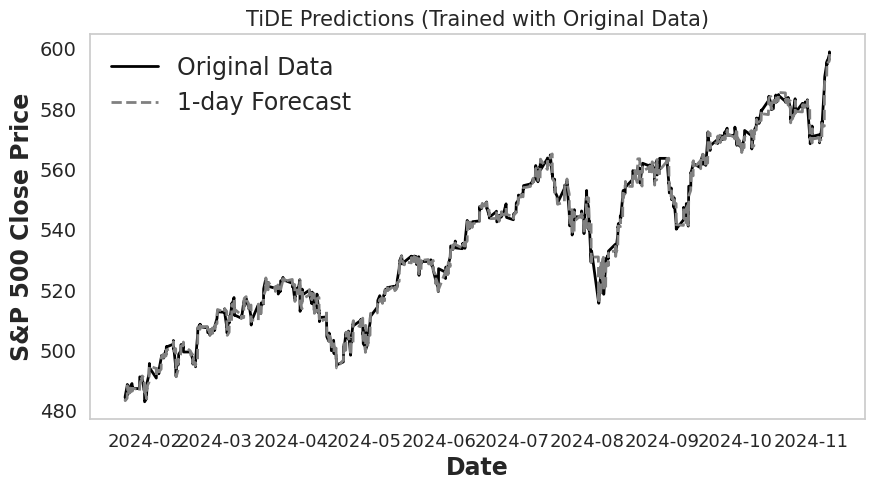

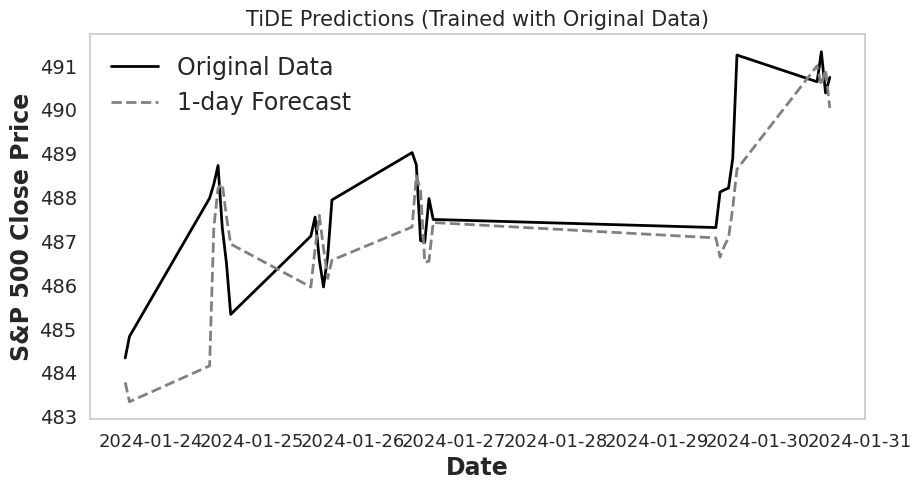


Directional Movement Metrics:

TiDE (Original) | Train Accuracy: 55.70%
TiDE (Original) | Validation Accuracy: 49.63%
TiDE (Original) | Test Accuracy: 50.04%
TiDE (Original) | Recall: 54.42%
TiDE (Original) | Precision (Rise): 52.35%
TiDE (Original) | Precision (Fall): 47.27%
TiDE (Original) | F1 Score: 53.36%


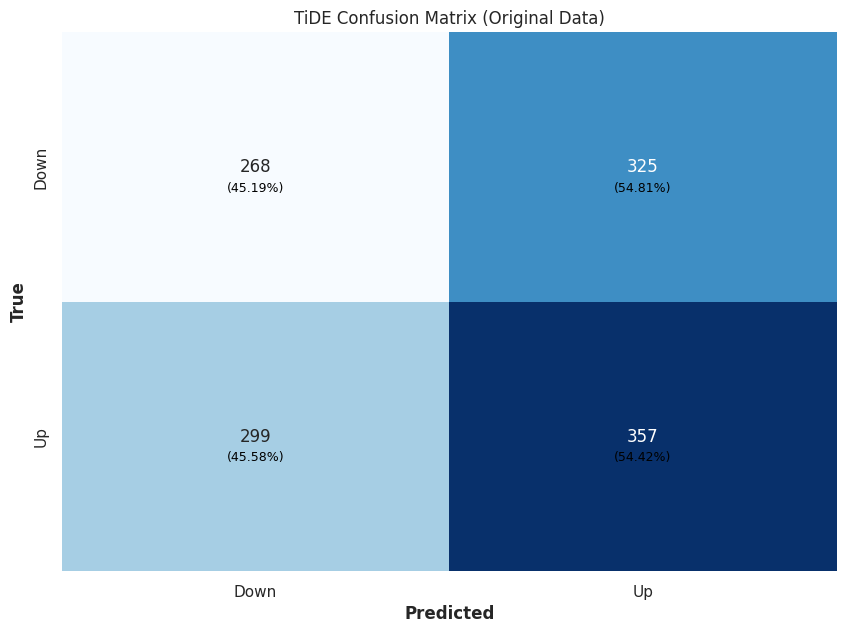

In [ ]:
model = get_model_tide()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Price Prediction Metrics:

TiDE (Denoised) | MAE: 0.98
TiDE (Denoised) | MSE: 2.05
TiDE (Denoised) | RMSE: 1.43
TiDE (Denoised) | RMSSE: 0.80
TiDE (Denoised) | MAPE: 0.18%
TiDE (Denoised) | MASE: 0.91
TiDE (Denoised) | R2: 1.00


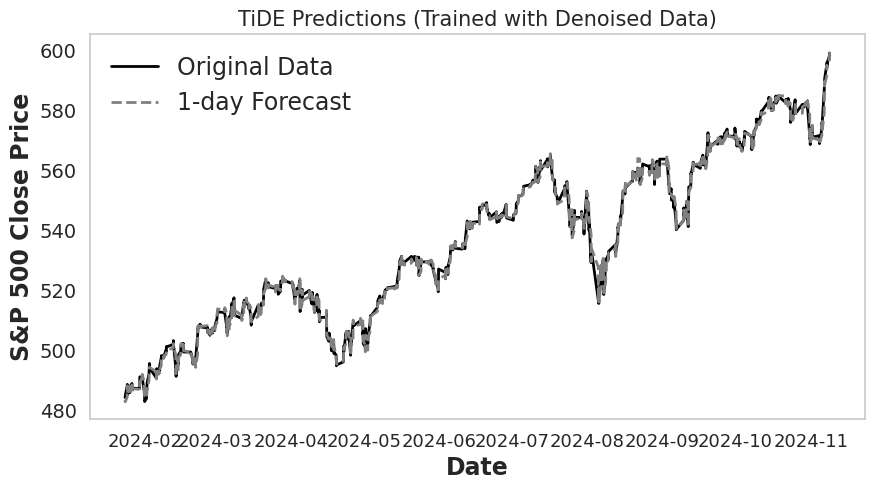

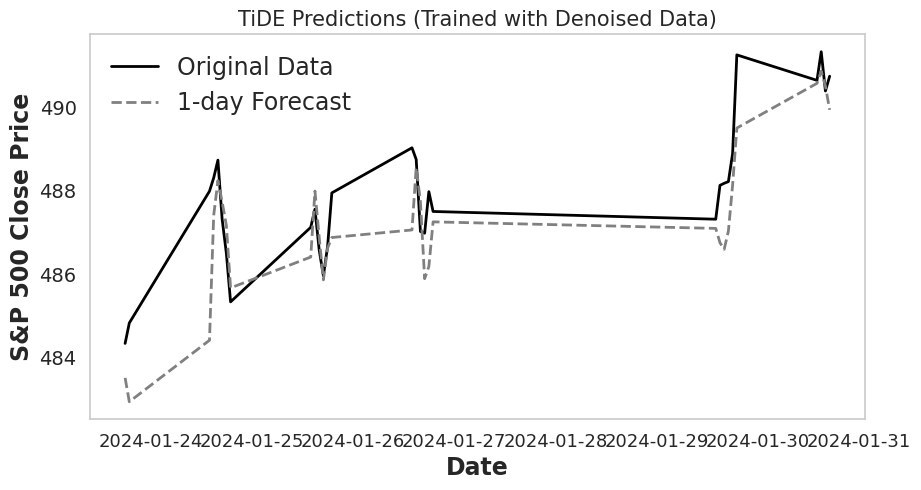


Directional Movement Metrics:

TiDE (Denoised) | Train Accuracy: 66.92%
TiDE (Denoised) | Validation Accuracy: 63.48%
TiDE (Denoised) | Test Accuracy: 63.49%
TiDE (Denoised) | Recall: 66.77%
TiDE (Denoised) | Precision (Rise): 64.79%
TiDE (Denoised) | Precision (Fall): 61.95%
TiDE (Denoised) | F1 Score: 65.77%


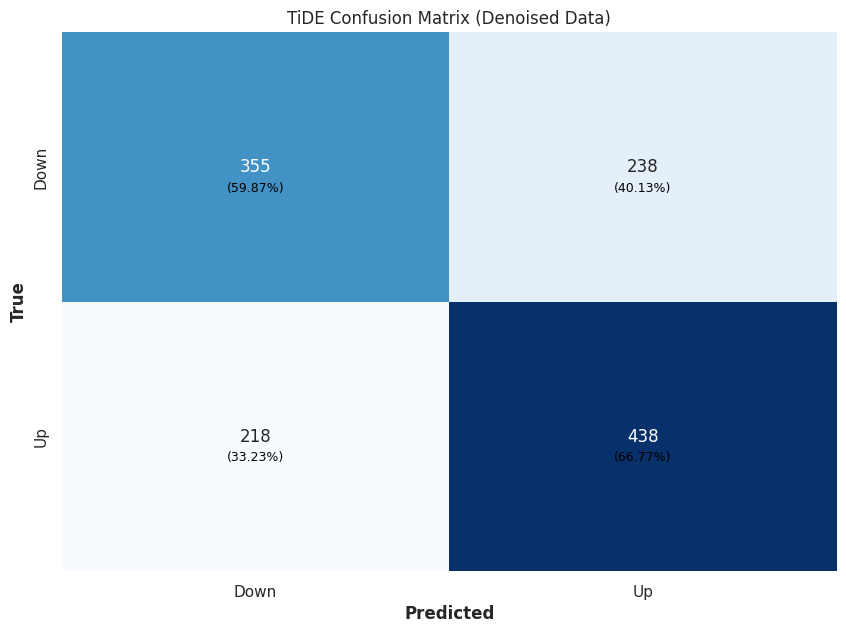

In [ ]:
model = get_model_tide()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### N-HiTS

**Neural Hierarchical Interpolation for Time Series Forecasting**

References:

- Paper (2022): https://doi.org/10.48550/arXiv.2201.12886
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/nhits.py
- Darts documentation: https://unit8co.github.io/darts/examples/18-TiDE-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-HiTS (Original) | MAE: 1.82
N-HiTS (Original) | MSE: 7.52
N-HiTS (Original) | RMSE: 2.74
N-HiTS (Original) | RMSSE: 1.54
N-HiTS (Original) | MAPE: 0.34%
N-HiTS (Original) | MASE: 1.69
N-HiTS (Original) | R2: 0.99


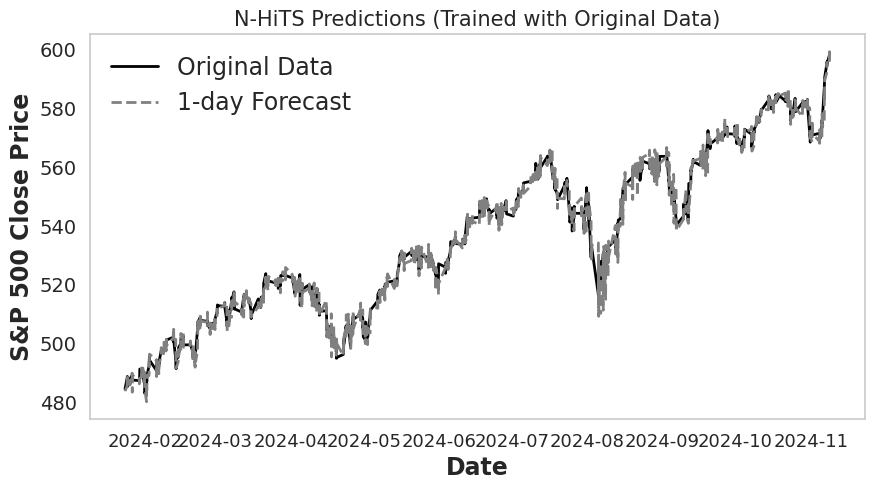

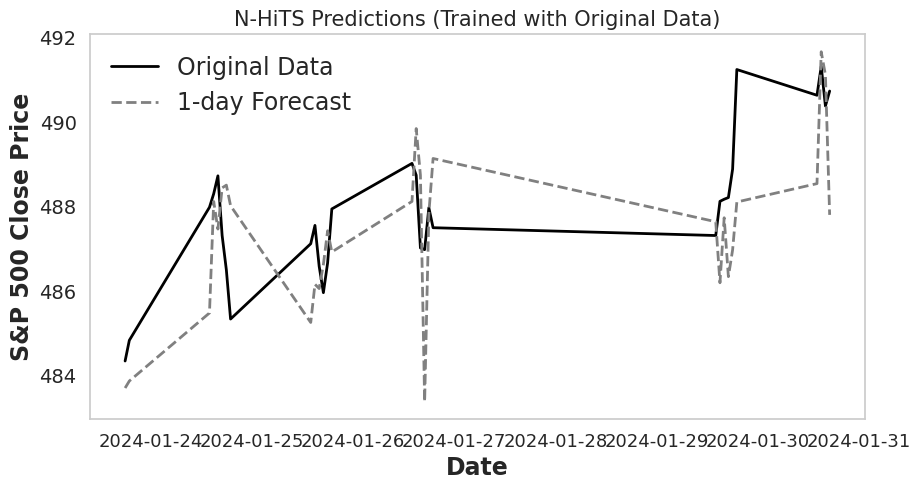


Directional Movement Metrics:

N-HiTS (Original) | Train Accuracy: 51.70%
N-HiTS (Original) | Validation Accuracy: 50.22%
N-HiTS (Original) | Test Accuracy: 51.40%
N-HiTS (Original) | Recall: 52.74%
N-HiTS (Original) | Precision (Rise): 53.81%
N-HiTS (Original) | Precision (Fall): 48.84%
N-HiTS (Original) | F1 Score: 53.27%


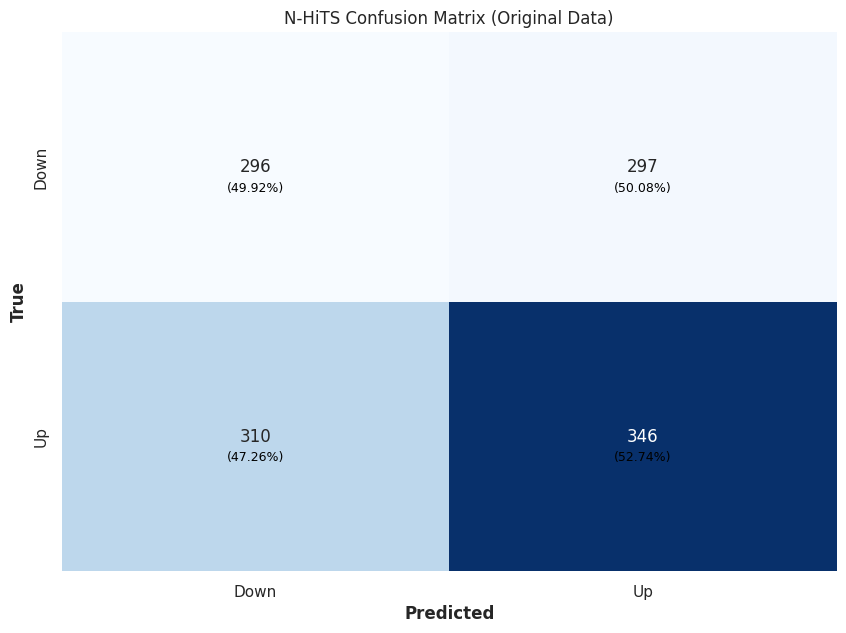

In [ ]:
model = get_model_nhits()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-HiTS (Denoised) | MAE: 1.47
N-HiTS (Denoised) | MSE: 4.57
N-HiTS (Denoised) | RMSE: 2.14
N-HiTS (Denoised) | RMSSE: 1.20
N-HiTS (Denoised) | MAPE: 0.27%
N-HiTS (Denoised) | MASE: 1.36
N-HiTS (Denoised) | R2: 0.99


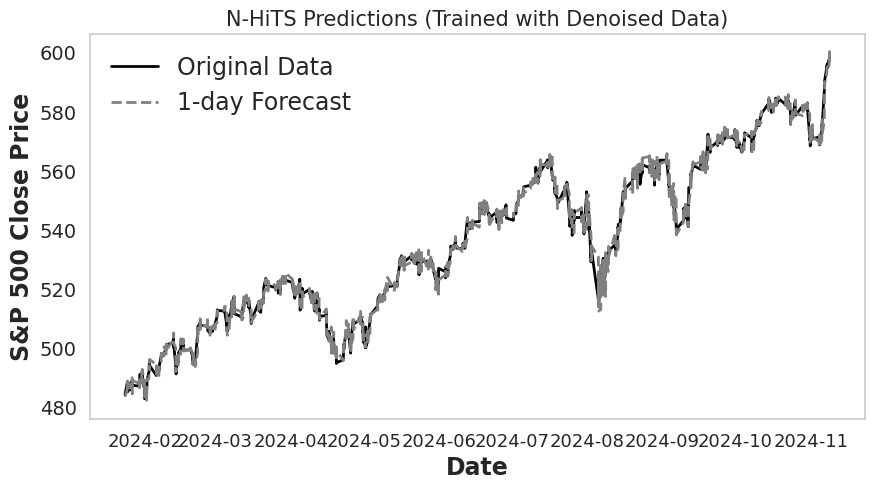

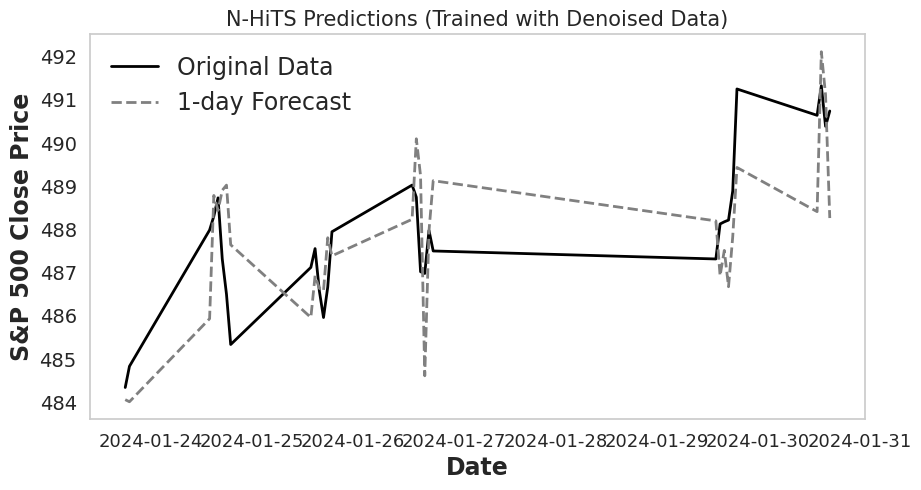


Directional Movement Metrics:

N-HiTS (Denoised) | Train Accuracy: 57.70%
N-HiTS (Denoised) | Validation Accuracy: 57.00%
N-HiTS (Denoised) | Test Accuracy: 56.53%
N-HiTS (Denoised) | Recall: 58.54%
N-HiTS (Denoised) | Precision (Rise): 58.63%
N-HiTS (Denoised) | Precision (Fall): 54.21%
N-HiTS (Denoised) | F1 Score: 58.58%


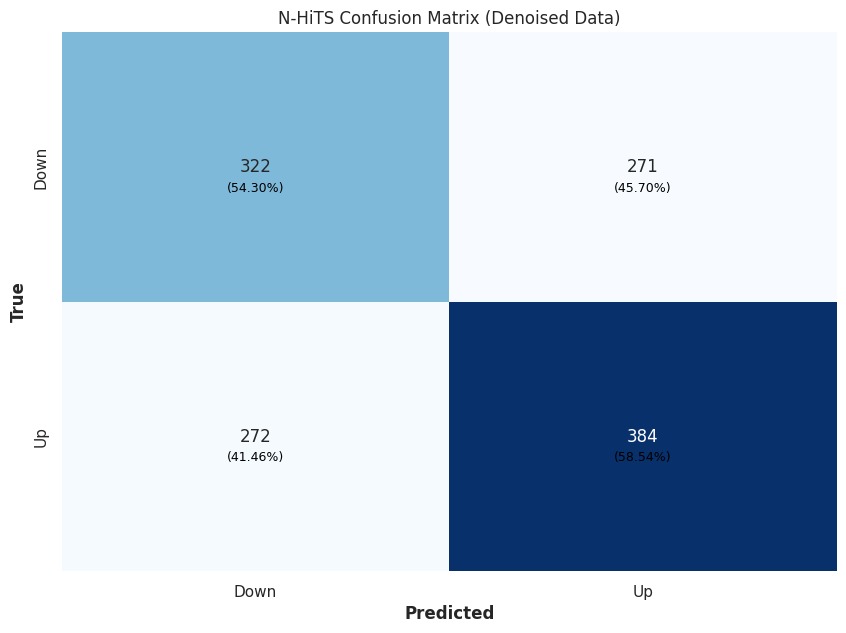

In [ ]:
model = get_model_nhits()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### TSMixer

TimeSeries Mixer Model

**References**:
- Paper (2023): https://doi.org/10.48550/arXiv.2303.06053
- Code: https://github.com/ditschuk/pytorch-tsmixer
- Darts documentation: https://unit8co.github.io/darts/examples/21-TSMixer-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TSMixer (Original) | MAE: 4.32
TSMixer (Original) | MSE: 39.12
TSMixer (Original) | RMSE: 6.25
TSMixer (Original) | RMSSE: 3.50
TSMixer (Original) | MAPE: 0.81%
TSMixer (Original) | MASE: 4.01
TSMixer (Original) | R2: 0.95


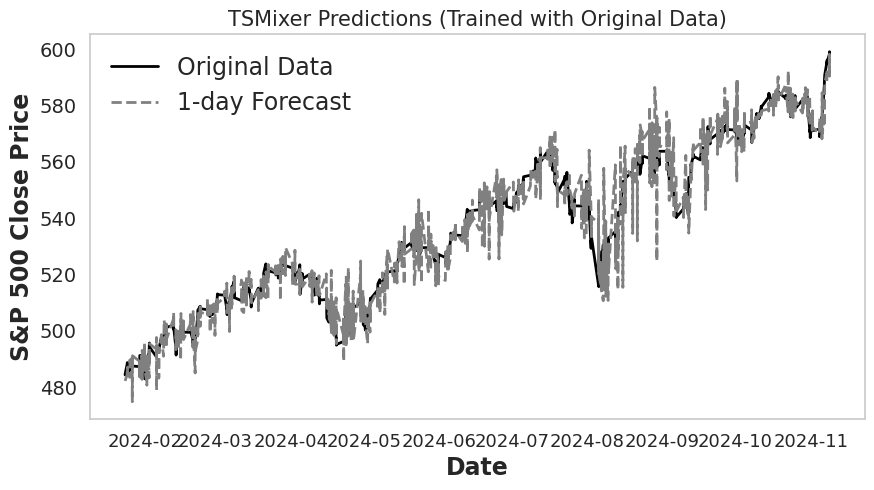

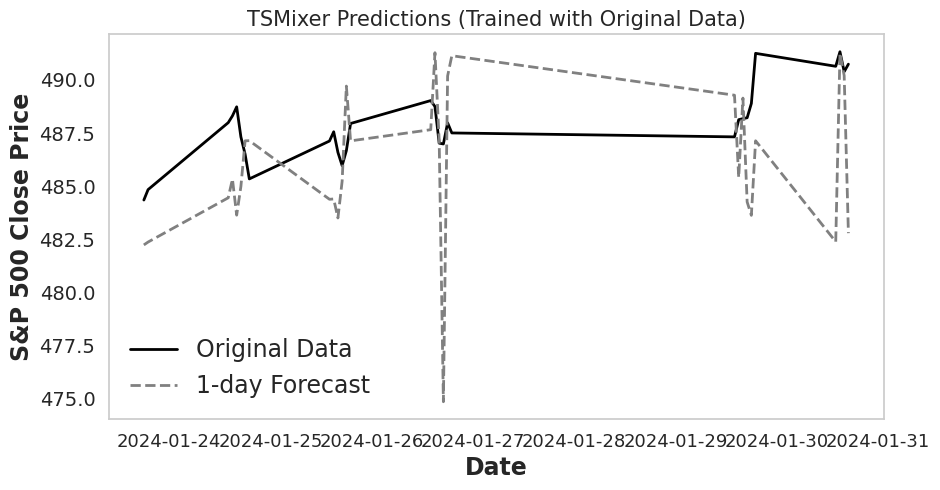


Directional Movement Metrics:

TSMixer (Original) | Train Accuracy: 50.30%
TSMixer (Original) | Validation Accuracy: 52.28%
TSMixer (Original) | Test Accuracy: 51.56%
TSMixer (Original) | Recall: 52.13%
TSMixer (Original) | Precision (Rise): 54.03%
TSMixer (Original) | Precision (Fall): 49.03%
TSMixer (Original) | F1 Score: 53.06%


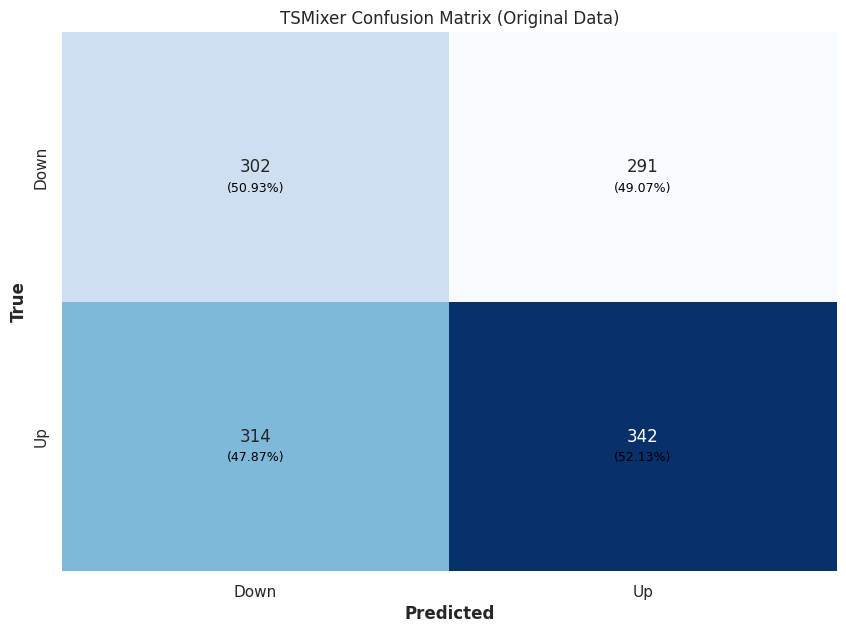

In [ ]:
model = get_model_tsm()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TSMixer (Denoised) | MAE: 4.21
TSMixer (Denoised) | MSE: 37.48
TSMixer (Denoised) | RMSE: 6.12
TSMixer (Denoised) | RMSSE: 3.43
TSMixer (Denoised) | MAPE: 0.78%
TSMixer (Denoised) | MASE: 3.90
TSMixer (Denoised) | R2: 0.95


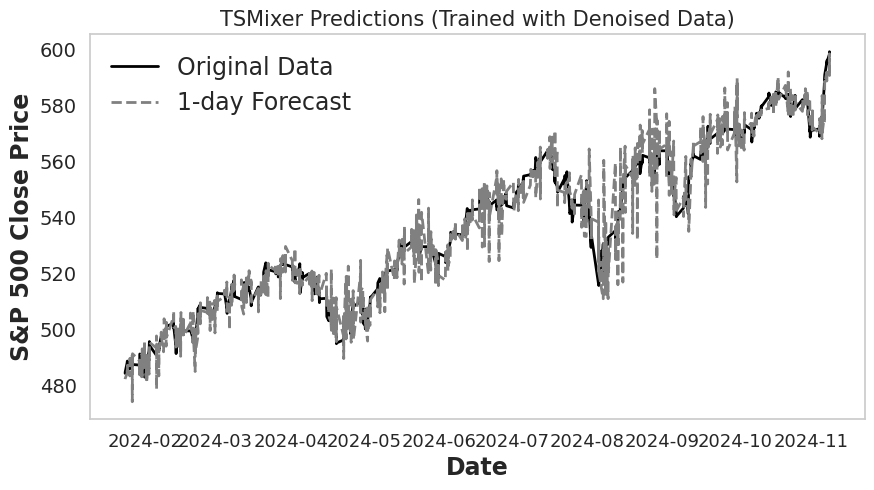

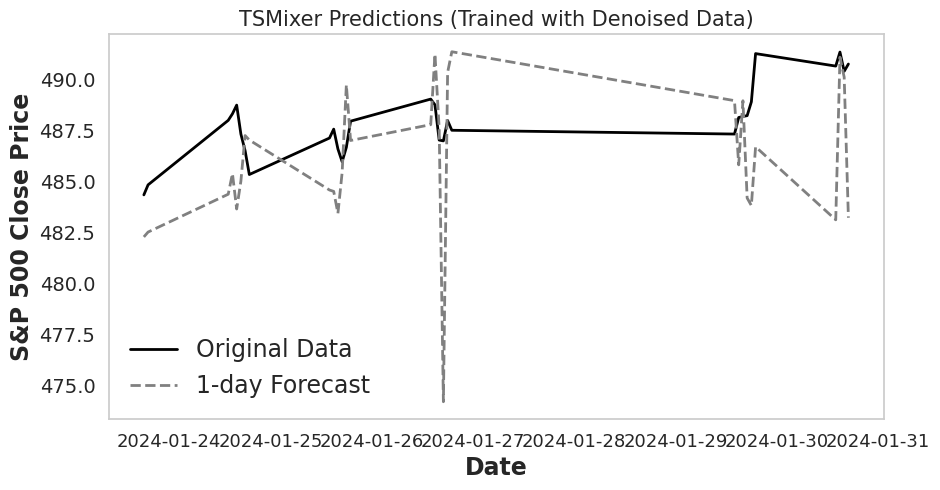


Directional Movement Metrics:

TSMixer (Denoised) | Train Accuracy: 50.67%
TSMixer (Denoised) | Validation Accuracy: 52.28%
TSMixer (Denoised) | Test Accuracy: 51.40%
TSMixer (Denoised) | Recall: 51.83%
TSMixer (Denoised) | Precision (Rise): 53.88%
TSMixer (Denoised) | Precision (Fall): 48.87%
TSMixer (Denoised) | F1 Score: 52.84%


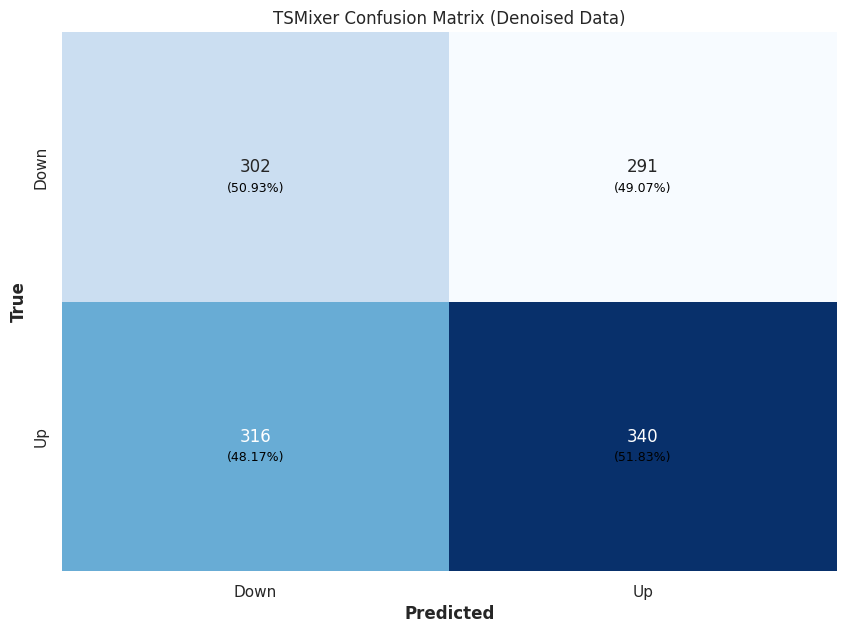

In [ ]:
model = get_model_tsm()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### New proposed model: xLSTM-TS, a time series-specific implementation

**References:**

- Paper (2024): https://doi.org/10.48550/arXiv.2405.04517

- Official code: https://github.com/NX-AI/xlstm

- Parameters for time series: https://github.com/smvorwerk/xlstm-cuda

#### Configuration

In [ ]:
from ml.models.xlstm_ts.xlstm_ts_model import *
from ml.models.xlstm_ts.logic import *

In [ ]:
plot_architecture_xlstm()

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=2', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_H

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


#### Training and evaluation

In [ ]:
model_name = 'xLSTM-TS'

**Not denoised**

Epoch [1/200], Loss: 0.00001222, Validation Loss: 0.00004306
Epoch [2/200], Loss: 0.00016908, Validation Loss: 0.00013550
Epoch [3/200], Loss: 0.00013781, Validation Loss: 0.00012150
Epoch [4/200], Loss: 0.00000547, Validation Loss: 0.00002660
Epoch [5/200], Loss: 0.00000777, Validation Loss: 0.00004305
Epoch [6/200], Loss: 0.00001736, Validation Loss: 0.00003173
Epoch [7/200], Loss: 0.00003846, Validation Loss: 0.00002713
Epoch [8/200], Loss: 0.00000789, Validation Loss: 0.00002964
Epoch [9/200], Loss: 0.00000614, Validation Loss: 0.00006268
Epoch [10/200], Loss: 0.00002299, Validation Loss: 0.00007344
Epoch [11/200], Loss: 0.00022739, Validation Loss: 0.00010993
Epoch [12/200], Loss: 0.00000608, Validation Loss: 0.00003079
Epoch [13/200], Loss: 0.00004082, Validation Loss: 0.00003377
Epoch [14/200], Loss: 0.00001242, Validation Loss: 0.00002390
Epoch [15/200], Loss: 0.00000621, Validation Loss: 0.00002726
Epoch [16/200], Loss: 0.00003098, Validation Loss: 0.00003249
Epoch [17/200], L

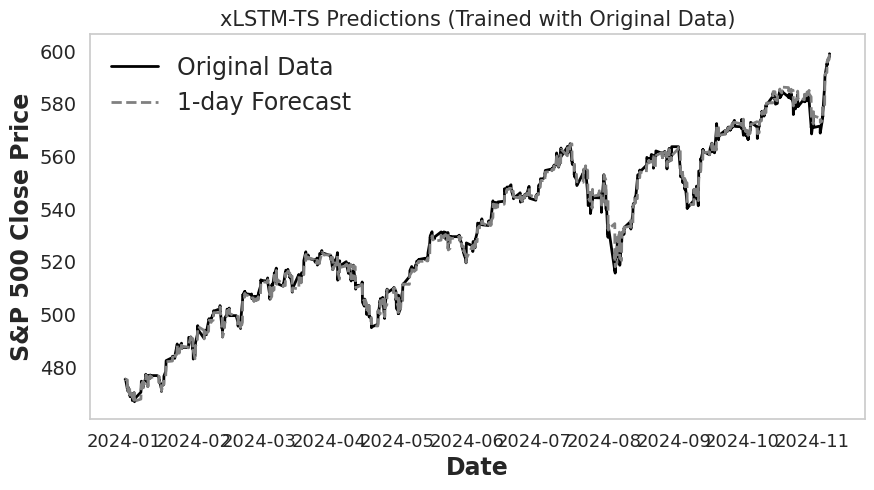

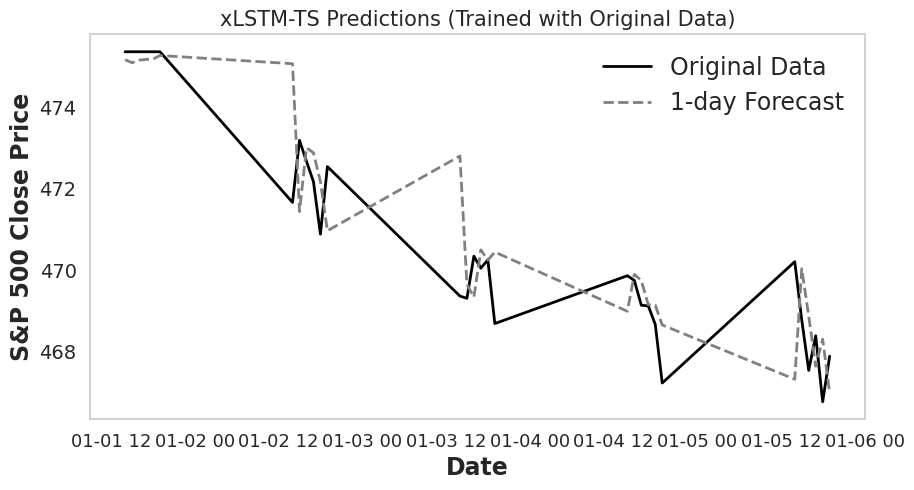

xLSTM-TS (Original) | Train Accuracy: 50.97%
xLSTM-TS (Original) | Validation Accuracy: 47.11%
xLSTM-TS (Original) | Test Accuracy: 50.11%
xLSTM-TS (Original) | Recall: 55.45%
xLSTM-TS (Original) | Precision (Rise): 52.27%
xLSTM-TS (Original) | Precision (Fall): 47.41%
xLSTM-TS (Original) | F1 Score: 53.81%


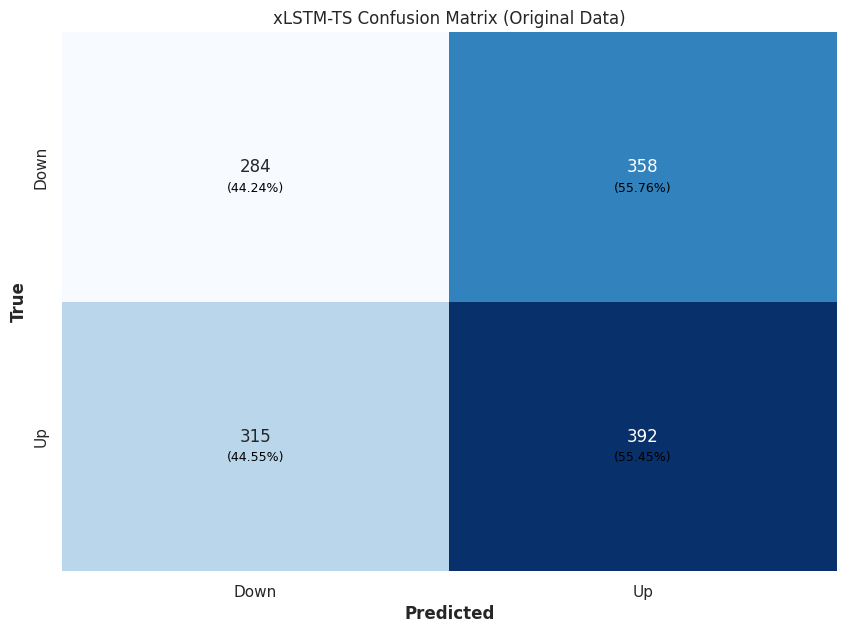

In [ ]:
results_df, metrics = run_xlstm_ts(train_X, train_y, val_X, val_y, test_X, test_y, scaler, STOCK, 'Original', test_dates)

In [ ]:
metrics_accumulator[model_name] = metrics

**Denoised**

Epoch [1/200], Loss: 0.00051406, Validation Loss: 0.00026600
Epoch [2/200], Loss: 0.00071999, Validation Loss: 0.00020254
Epoch [3/200], Loss: 0.00014904, Validation Loss: 0.00015651
Epoch [4/200], Loss: 0.00003216, Validation Loss: 0.00005947
Epoch [5/200], Loss: 0.00012682, Validation Loss: 0.00011088
Epoch [6/200], Loss: 0.00011019, Validation Loss: 0.00007525
Epoch [7/200], Loss: 0.00005217, Validation Loss: 0.00002298
Epoch [8/200], Loss: 0.00000689, Validation Loss: 0.00002306
Epoch [9/200], Loss: 0.00009198, Validation Loss: 0.00009117
Epoch [10/200], Loss: 0.00005548, Validation Loss: 0.00002246
Epoch [11/200], Loss: 0.00002184, Validation Loss: 0.00003298
Epoch [12/200], Loss: 0.00004452, Validation Loss: 0.00009952
Epoch [13/200], Loss: 0.00001588, Validation Loss: 0.00001866
Epoch [14/200], Loss: 0.00000547, Validation Loss: 0.00003240
Epoch [15/200], Loss: 0.00001816, Validation Loss: 0.00002827
Epoch [16/200], Loss: 0.00000647, Validation Loss: 0.00001553
Epoch [17/200], L

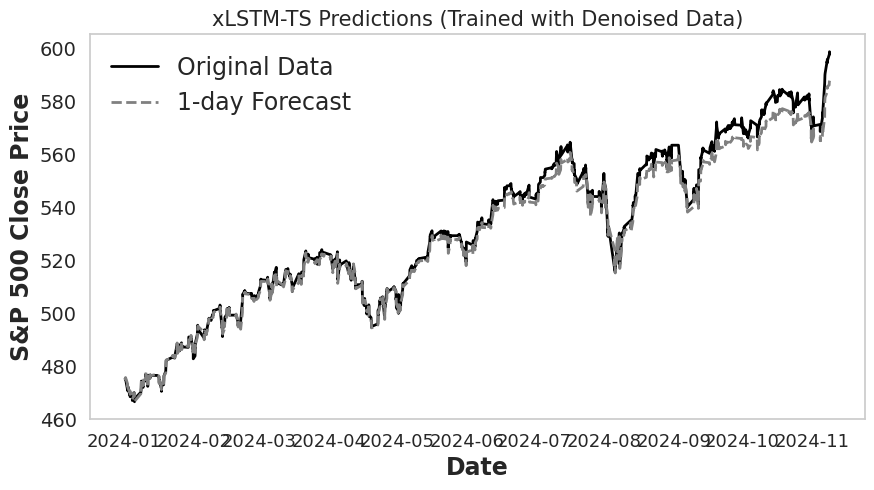

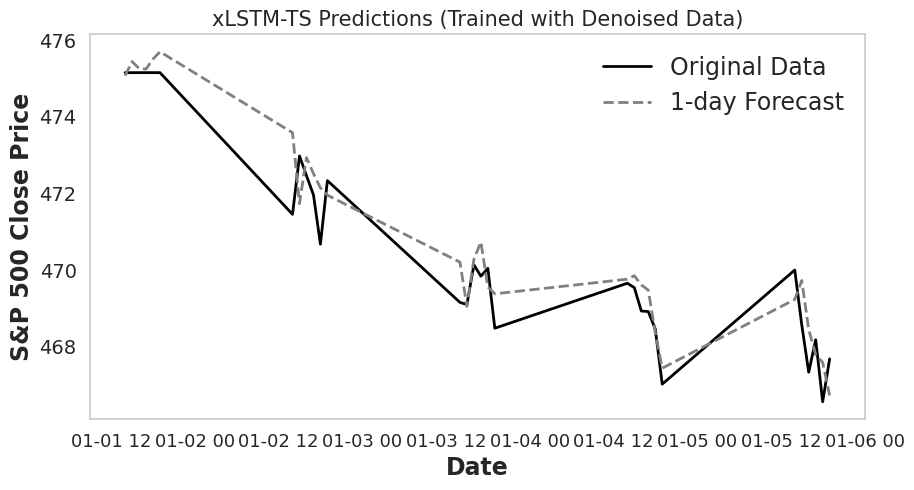

xLSTM-TS (Denoised) | Train Accuracy: 66.13%
xLSTM-TS (Denoised) | Validation Accuracy: 64.31%
xLSTM-TS (Denoised) | Test Accuracy: 68.05%
xLSTM-TS (Denoised) | Recall: 71.57%
xLSTM-TS (Denoised) | Precision (Rise): 68.75%
xLSTM-TS (Denoised) | Precision (Fall): 67.21%
xLSTM-TS (Denoised) | F1 Score: 70.13%


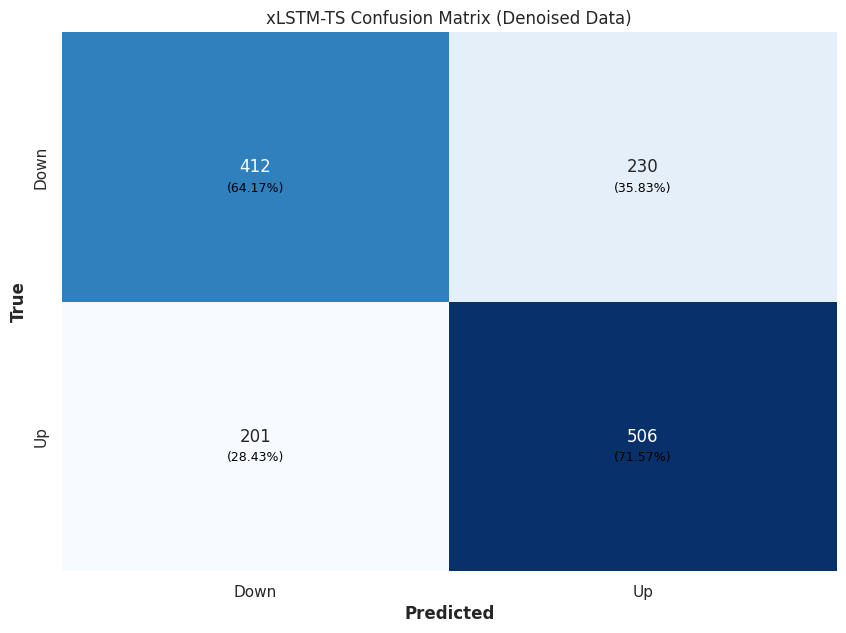

In [ ]:
results_denoised_df, metrics_denoised = run_xlstm_ts(train_X_denoised, train_y_denoised, val_X_denoised, val_y_denoised, test_X_denoised, test_y, scaler_denoised, STOCK, 'Denoised', test_dates, train_y, val_y, test_y)

In [ ]:
metrics_accumulator_denoised[model_name] = metrics_denoised

## Results

In [ ]:
from ml.results.results import *

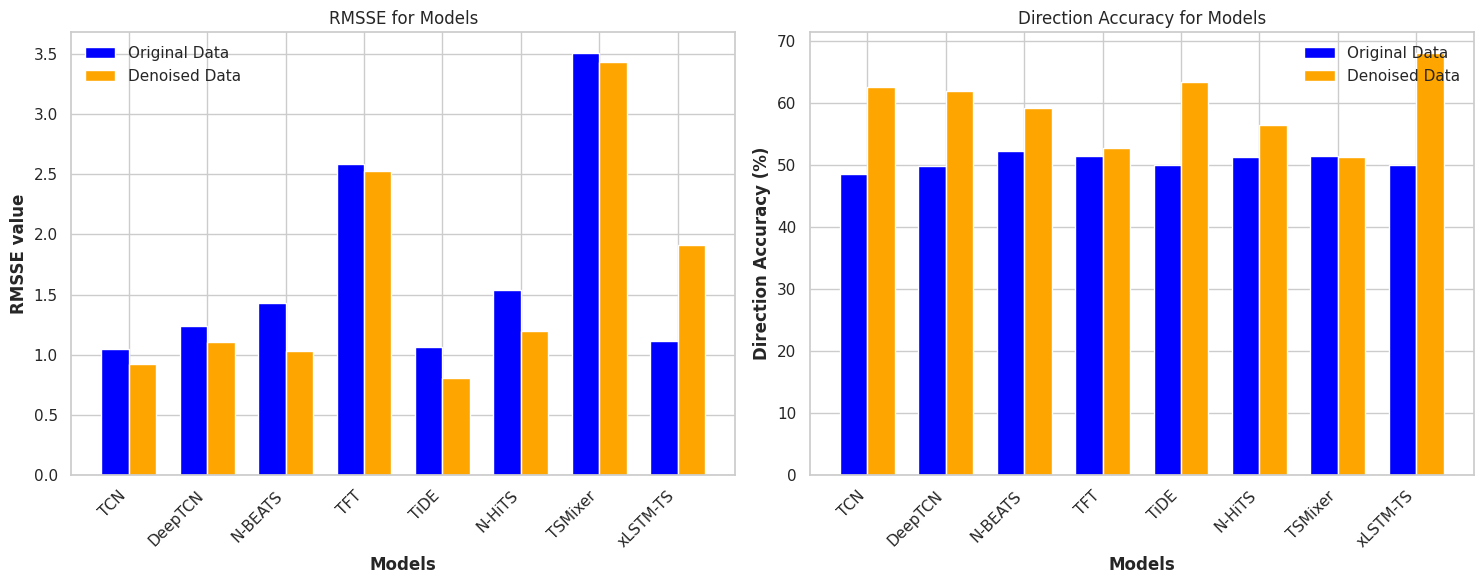

In [ ]:
final_results = display_metrics(metrics_accumulator, metrics_accumulator_denoised)

In [ ]:
original_data = show_results(final_results, 'Original')
denoised_data = show_results(final_results, 'Denoised')

In [ ]:
original_data

MAE    MSE  RMSE  RMSSE   MAPE  MASE    R2 Test Accuracy  Recall  \
xLSTM-TS  1.31   3.76  1.94   1.11  0.25%  1.24  1.00        50.11%  55.45%   
TSMixer   4.32  39.12  6.25   3.50  0.81%  4.01  0.95        51.56%  52.13%   
N-HiTS    1.82   7.52  2.74   1.54  0.34%  1.69  0.99        51.40%  52.74%   
TiDE      1.24   3.58  1.89   1.06  0.23%  1.15  1.00        50.04%  54.42%   
TFT       2.97  21.32  4.62   2.59  0.55%  2.75  0.97        51.56%  52.74%   
N-BEATS   1.72   6.48  2.55   1.43  0.32%  1.60  0.99        52.36%  54.12%   
DeepTCN   1.53   4.87  2.21   1.24  0.28%  1.42  0.99        49.80%  54.12%   
TCN       1.21   3.50  1.87   1.05  0.23%  1.12  1.00        48.52%  53.81%   

         Precision (Rise) Precision (Fall) F1 Score Validation Accuracy  \
xLSTM-TS           52.27%           47.41%   53.81%              47.11%   
TSMixer            54.03%           49.03%   53.06%              52.28%   
N-HiTS             53.81%           48.84%   53.27%              50.22%   
TiDE               52.35%           47.27%   53.36%              49.63%   
TFT                53.98%           49.01%   53.35%              50.52%   
N-BEATS            54.70%           49.83%   54.41%              51.40%   
DeepTCN            52.13%           47.01%   53.10%              45.36%   
TCN                50.94%           45.50%   52.34%              49.04%   

         Train Accuracy  
xLSTM-TS         50.97%  
TSMixer          50.30%  
N-HiTS           51.70%  
TiDE             55.70%  
TFT              50.74%  
N-BEATS          54.01%  
DeepTCN          50.63%  
TCN              51.42%

In [ ]:
denoised_data

MAE    MSE  RMSE  RMSSE   MAPE  MASE    R2 Test Accuracy  Recall  \
xLSTM-TS  2.49  11.14  3.34   1.91  0.45%  2.35  0.99        68.05%  71.57%   
TSMixer   4.21  37.48  6.12   3.43  0.78%  3.90  0.95        51.40%  51.83%   
N-HiTS    1.47   4.57  2.14   1.20  0.27%  1.36  0.99        56.53%  58.54%   
TiDE      0.98   2.05  1.43   0.80  0.18%  0.91  1.00        63.49%  66.77%   
TFT       2.88  20.39  4.52   2.53  0.54%  2.67  0.97        52.84%  53.96%   
N-BEATS   1.26   3.40  1.84   1.03  0.24%  1.17  1.00        59.17%  62.65%   
DeepTCN   1.35   3.87  1.97   1.10  0.25%  1.25  0.99        62.05%  65.55%   
TCN       1.08   2.70  1.64   0.92  0.20%  1.00  1.00        62.69%  67.84%   

         Precision (Rise) Precision (Fall) F1 Score Validation Accuracy  \
xLSTM-TS           68.75%           67.21%   70.13%              64.31%   
TSMixer            53.88%           48.87%   52.84%              52.28%   
N-HiTS             58.63%           54.21%   58.58%              57.00%   
TiDE               64.79%           61.95%   65.77%              63.48%   
TFT                55.23%           50.33%   54.59%              51.69%   
N-BEATS            60.80%           57.24%   61.71%              57.73%   
DeepTCN            63.42%           60.42%   64.47%              62.15%   
TCN                63.57%           61.57%   65.63%              60.82%   

         Train Accuracy  
xLSTM-TS         66.13%  
TSMixer          50.67%  
N-HiTS           57.70%  
TiDE             66.92%  
TFT              53.29%  
N-BEATS          62.21%  
DeepTCN          65.09%  
TCN              64.15%

## Export

Only for denoised values.

In [ ]:
results_df.head(10)

Date       Close  Predicted Value  True Label  \
0 2024-01-01 14:00:00  475.360016       475.164703           0   
1 2024-01-01 15:00:00  475.360016       475.090149           0   
2 2024-01-01 16:00:00  475.360016       475.152405           0   
3 2024-01-01 17:00:00  475.360016       475.172272           0   
4 2024-01-01 18:00:00  475.360016       475.178497           0   
5 2024-01-01 19:00:00  475.360016       475.267517           0   
6 2024-01-02 14:00:00  471.659973       475.066498           1   
7 2024-01-02 15:00:00  473.184998       471.435211           0   
8 2024-01-02 16:00:00  472.670013       473.001526           0   
9 2024-01-02 17:00:00  472.169983       472.876984           0   

   Predicted Label  
0                0  
1                1  
2                1  
3                1  
4                1  
5                0  
6                0  
7                1  
8                0  
9                0

In [ ]:
results_denoised_df.head(10)

Date       Close  Predicted Value  True Label  \
0 2024-01-01 14:00:00  475.147736       475.067719           0   
1 2024-01-01 15:00:00  475.147736       475.435883           0   
2 2024-01-01 16:00:00  475.147736       475.255707           0   
3 2024-01-01 17:00:00  475.147736       475.241364           0   
4 2024-01-01 18:00:00  475.147736       475.502045           0   
5 2024-01-01 19:00:00  475.147736       475.692749           0   
6 2024-01-02 14:00:00  471.451569       473.581055           1   
7 2024-01-02 15:00:00  472.975006       471.729370           0   
8 2024-01-02 16:00:00  472.460510       472.933075           0   
9 2024-01-02 17:00:00  471.961060       472.515656           0   

   Predicted Label  
0                1  
1                0  
2                0  
3                1  
4                1  
5                0  
6                0  
7                1  
8                0  
9                0

In [ ]:
# -- Save predictions as CSV --

%cd ..

save_results(results_df, results_denoised_df, FILE_NAME)

# -- Save the xLSTM-TS model --

# Rename the file
!mv xlstm-ts/xlstm_ts_model.pth xlstm_model_{FILE_NAME}.pth

# Download if necessary

/content
